In [1]:
import numpy as np
import pytreenet as ptn
from copy import deepcopy
np.random.seed(82)

In [2]:
d = 3

In [3]:
def save_list(list_to_save, filename):
    filename = f"results/{filename}"
    with open(filename, 'w') as file:
        for item in list_to_save:
            file.write(str(item) + '\n')
    print(f"List saved to {filename}")

def load_list(filename):
    filename = f"results/{filename}"
    try:
        with open(filename, 'r') as file:
            return [complex(line.strip()) for line in file.readlines()]
    except FileNotFoundError:
        print(f"File {filename} not found.")
        return []

In [4]:
def product_state(ttn, bond_dim=2 , physical_dim= 2):
    product_state = deepcopy(ttn)
    # A = np.asarray(d*[1j/np.sqrt(physical_dim)])
    A = np.array([0,1j* 1/np.sqrt(2),1j * 1/np.sqrt(2)])
    for node_id in product_state.nodes.keys():
        n = product_state.tensors[node_id].ndim - 1
        tensor = A.reshape((1,) * n + (physical_dim,))
        T = np.pad(tensor, n*((0, bond_dim-1),) + ((0, 0),))
        product_state.tensors[node_id] = T
        product_state.nodes[node_id].link_tensor(T)  
    return product_state

In [5]:
shapes = {
    (0, 0): (2, 2, 2, d),
    (0, 1): (2, 2, d),
    (0, 2): (2, 2, d),
    (1, 0): (2, 2, d),
    (1, 1): (2, d),
    (1, 2): (2, d),
    (2, 0): (2, 2, d),
    (2, 1): (2, 2, 2, d),
    (2, 2): (2, d)
}


sites = {
    (i, j): ptn.random_tensor_node(shapes[(i, j)], identifier=f"Site({i},{j})") for i in range(3) for j in range(3)
}

ttn = ptn.TreeTensorNetworkState()

ttn.add_root(sites[(0, 0)][0], sites[(0, 0)][1])

connections = [
    ((0, 0), (0, 1), 0, 0),
    ((0, 1), (0, 2), 1, 0),
    ((0, 2), (1, 2), 1, 0),
    ((0, 0), (1, 0), 1, 0),
    ((1, 0), (2, 0), 1, 0),
    ((2, 0), (2, 1), 1, 0),
    ((2, 1), (1, 1), 1, 0),
    ((2, 1), (2, 2), 2, 0)]


for (parent, child, parent_leg, child_leg) in connections:
    parent_id = f"Site({parent[0]},{parent[1]})"
    child_id = f"Site({child[0]},{child[1]})"
    ttn.add_child_to_parent(sites[child][0], sites[child][1], child_leg, parent_id, parent_leg)

# ttn = product_state(ttn , bond_dim= 2, physical_dim = d)

nodes = {
    (i, j): (ptn.Node(tensor=ttn.tensors[f"Site({i},{j})"].conj() , identifier=f"Node({i},{j})"), ttn.tensors[f"Site({i},{j})"].conj()) for i in range(3) for j in range(3)
}

ttn.add_child_to_parent(nodes[(0,0)][0], nodes[(0,0)][1], 2, "Site(0,0)", 2)

connections = [
    ((0, 0), (0, 1), 1, 0),
    ((0, 1), (0, 2), 1, 0),
    ((0, 2), (1, 2), 1, 0),
    ((0, 0), (1, 0), 2, 0),
    ((1, 0), (2, 0), 1, 0),
    ((2, 0), (2, 1), 1, 0),
    ((2, 1), (1, 1), 1, 0),
    ((2, 1), (2, 2), 2, 0),
]

for (parent, child, parent_leg, child_leg) in connections:
    parent_id = f"Node({parent[0]},{parent[1]})"
    child_id = f"Node({child[0]},{child[1]})"
    ttn.add_child_to_parent(nodes[child][0], nodes[child][1], child_leg, parent_id, parent_leg)

In [6]:
I = ptn.TTNO.Identity(ttn)
ptn.adjust_bra_to_ket(ttn)

for ket_id in [node.identifier for node in ttn.nodes.values() if str(node.identifier).startswith("S")]:
    bra_id = ket_id.replace('Site', 'Node')
    print(np.array_equal(ttn.tensors[ket_id].conj(), ttn.tensors[bra_id]))

ttn = ptn.normalize_ttn_Lindblad_4(ttn , "Node(1,1)")

for ket_id in [node.identifier for node in ttn.nodes.values() if str(node.identifier).startswith("S")]:
    bra_id = ket_id.replace('Site', 'Node')
    print(np.array_equal(ttn.tensors[ket_id].conj(), ttn.tensors[bra_id]))

ttn.operator_expectation_value_Lindblad(I)


True
True
True
True
True
True
True
True
True
False
True
True
True
False
False
False
False
True


array(1.+4.16333634e-17j)

In [7]:
def get_neighbors_Site(x, y, Lx, Ly):
  neighbors = []
  
  # Right neighbor
  if x < Lx - 1:
      neighbors.append(f"Site({x+1},{y})")
  
  # Up neighbor
  if y < Ly - 1:
      neighbors.append(f"Site({x},{y+1})")
  
  return neighbors

def get_neighbors_Node(x, y, Lx, Ly):
  neighbors = []

  # Right neighbor
  if x < Lx - 1:
      neighbors.append(f"Node({x+1},{y})")
  
  # Up neighbor
  if y < Ly - 1:
      neighbors.append(f"Node({x},{y+1})")
  
  return neighbors

In [8]:
def Liouville(t, U, J, m, L, Lx, Ly, d):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(d)
    
    conversion_dict = {
        "b^dagger": creation_op,
        "b": annihilation_op,
        f"I{d}": np.eye(d)


    }
    
    conversion_dict.update({
        "it * b^dagger": t*1j * creation_op,
        "it * b": t*1j * annihilation_op,
        "-iU * n * (n - 1)": -U*1j * number_op @ (number_op - np.eye(d)),
        "im*n": m*1j*number_op
    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            neighbors = get_neighbors_Site(x, y, Lx, Ly)            
            for neighbor in neighbors:
                terms.append(ptn.TensorProduct({current_site: "it * b^dagger", neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "it * b", neighbor: "b^dagger"}))
                

    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "-iU * n * (n - 1)"}))

    # Chemical potential terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "im*n"}))        
    
    H1 = ptn.Hamiltonian(terms, conversion_dict)
    
    conversion_dict = {
        "b^dagger.T": creation_op.T,
        "b.T": annihilation_op.T,
        f"I{d}": np.eye(d)
    }
    
    conversion_dict.update({
        "-it * b^dagger.T": -t*1j * creation_op.T,
        "-it * b.T": -t*1j * annihilation_op.T,
        "iU * n * (n - 1).T": (U*1j * number_op @ (number_op - np.eye(d))).T,
        "-im*n.T": -m*1j* number_op.T

    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            neighbors = get_neighbors_Node(x, y, Lx, Ly)
            for neighbor in neighbors:
                terms.append(ptn.TensorProduct({current_site: "-it * b^dagger.T", neighbor: "b.T"}))
                terms.append(ptn.TensorProduct({current_site: "-it * b.T", neighbor: "b^dagger.T"}))

    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "iU * n * (n - 1).T"}))    

    # Chemical potential terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "-im*n.T"}))
            
    H2 = ptn.Hamiltonian(terms, conversion_dict)
    H1.__add__(H2)

    
    J = np.sqrt(J)
    conversion_dict = {    
    "L": J*L,
    "L^dagger.T": J*L.conj(),
    "-1/2 (L^dagger @ L) ": -1/2 * J *  L.conj().T @ L,
    "-1/2 (L^dagger @ L).T":-1/2 * J * (L.conj().T @ L).T}

    terms = []
    for x in range(Lx):
        for y in range(Ly):
            out_site = f"Node({x},{y})"
            in_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({in_site: "L"}))
            terms.append(ptn.TensorProduct({out_site: "L^dagger.T"}))
            terms.append(ptn.TensorProduct({in_site: "-1/2 (L^dagger @ L) "}))
            terms.append(ptn.TensorProduct({out_site: "-1/2 (L^dagger @ L).T"}))

    H3 = ptn.Hamiltonian(terms, conversion_dict)
    H1.__add__(H3)
    return H1

In [9]:
def Unitary(t, U, m, Lx, Ly, d):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(d)
    
    conversion_dict = {
        "b^dagger": creation_op,
        "b": annihilation_op,
        f"I{d}": np.eye(d)
    }
    
    conversion_dict.update({
        "it * b^dagger": t * 1.0j* creation_op,
        "it * b": t* 1.0j * annihilation_op,
        "-iU * n * (n - 1)": -U* 1.0j * number_op @ (number_op - np.eye(d)),
        "im*n": m *1j* number_op

    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            
            neighbors = get_neighbors_Site(x, y, Lx, Ly)
            
            for neighbor in neighbors:
                terms.append(ptn.TensorProduct({current_site: "it * b^dagger", neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "it * b", neighbor: "b^dagger"}))
    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "-iU * n * (n - 1)"}))
    
    # Chemical potential terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "im*n"}))

    H1 = ptn.Hamiltonian(terms, conversion_dict)
    
    conversion_dict = {
        "b^dagger.T": creation_op.T,
        "b.T": annihilation_op.T,
        f"I{d}": np.eye(d)
    }
    
    conversion_dict.update({
        "-it * b^dagger.T": -t* 1.0j * creation_op.T,
        "-it * b.T": -t* 1.0j * annihilation_op.T,
        "iU * n * (n - 1).T": (U* 1.0j* number_op @ (number_op - np.eye(d))).T,
        "-im*n.T": -m *1j* number_op.T
    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            neighbors = get_neighbors_Node(x, y, Lx, Ly)
            for neighbor in neighbors:
                terms.append(ptn.TensorProduct({current_site: "-it * b^dagger.T", neighbor: "b.T"}))
                terms.append(ptn.TensorProduct({current_site: "-it * b.T", neighbor: "b^dagger.T"}))
    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "iU * n * (n - 1).T"}))   

    # Chemical potential terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "-im*n.T"}))         

    H2 = ptn.Hamiltonian(terms, conversion_dict)
    H1.__add__(H2)
    return H1

In [10]:
def BoseHubbard_ham(t, U, m, Lx, Ly, d):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(d)
    
    conversion_dict = {
        "b^dagger": creation_op,
        "b": annihilation_op,
        f"I{d}": np.eye(d)}
    
    conversion_dict.update({
        "-t * b^dagger": -t * creation_op,
        "-t * b": -t * annihilation_op,
        "U * n * (n - 1)": U * number_op @ (number_op - np.eye(d)),
        "-m*n": -m * number_op
    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            neighbors = get_neighbors_Site(x, y, Lx, Ly)
            for neighbor in neighbors:
                terms.append(ptn.TensorProduct({current_site: "-t * b^dagger", neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "-t * b", neighbor: "b^dagger"}))


    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "U * n * (n - 1)"}))
    
    # Chemical potential terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "-m*n"}))

    return ptn.Hamiltonian(terms, conversion_dict)


In [11]:
def Number_op_total(Lx, Ly, dim=2):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(dim)
    conversion_dict = {"n": number_op , f"I{dim}": np.eye(dim)}

    terms = []
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "n"}))

    return ptn.Hamiltonian(terms, conversion_dict)     

def Number_op_local( node_id , dim=2):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(dim)
    conversion_dict = {"n": number_op , f"I{dim}": np.eye(dim)}

    terms = []
    terms.append(ptn.TensorProduct({node_id: "n"}))

    return ptn.Hamiltonian(terms, conversion_dict)

def Correlation_function(node_id1, node_id2, dim=2):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(dim)
    conversion_dict = {
        "b^dagger": creation_op,
        "b": annihilation_op,
        f"I{dim}": np.eye(dim)
    }
    
    terms = []
    terms.append(ptn.TensorProduct({node_id1: "b^dagger", node_id2: "b"}))
    return ptn.Hamiltonian(terms, conversion_dict)

In [12]:
def exchange_bra_ket_tensors(ttn):
    state = deepcopy(ttn)
    ptn.adjust_bra_to_ket(state)
    for ket_id in list(state.nodes.keys())[:(len(state.nodes.keys())//2)]:
        i, j = ket_id.replace('Site(', '').replace(')', '').split(',')
        bra_id = f"Node({i},{j})"
        T1 = state.tensors[bra_id]
        T2 = state.tensors[ket_id]
        state.tensors[ket_id] = T1
        state.nodes[ket_id].link_tensor(T1)
        state.tensors[bra_id] = T2
        state.nodes[bra_id].link_tensor(T2)
    return state

def substitute_out_or_in_legs_of_ttn_with_identity(state, out_or_in , bond_dim=2):
    ttn = deepcopy(state)
    if out_or_in == "Out":
       for node_id in list(ttn.nodes.keys())[(len(ttn.nodes.keys())//2):]:
        n = ttn.tensors[node_id].ndim - 1
        T = np.reshape(np.array([[1,0]]), (n*(1,) + (2,)))
        T = np.pad(T, n*((0, bond_dim-1),) + ((0, 0),))
        ttn.tensors[node_id] = T
        ttn.nodes[node_id].link_tensor(T)   
    if out_or_in == "In":
        for node_id in list(ttn.nodes.keys())[:len(ttn.nodes.keys())//2]:
            n = ttn.tensors[node_id].ndim
            T = ttn.tensors[node_id]
            T = np.reshape(np.array([[1,0]]), (n*(1,) + (2,)))
            T = np.pad(T, n*((0, bond_dim-1),) + ((0, 0),))
            ttn.tensors[node_id] = T
            ttn.nodes[node_id].link_tensor(T)        
    return ttn


In [13]:
t = 0.1
U = 0.1
m = 0.1

# TTNO : Hamiltonian acting on in_legs
H1 = BoseHubbard_ham(t, U, m, 3, 3, d)
H1 = H1.pad_with_identities(ttn, symbolic= True)
H = ptn.TTNO.from_hamiltonian(H1, ttn)

# TTNO : Liouville operator 
creation_op, annihilation_op, number_op = ptn.bosonic_operators(d)
L = annihilation_op 
J = 0.4
H1 = Liouville(t, U, J, m ,L, 3, 3, d)
H1 = H1.pad_with_identities(ttn , symbolic= True)
L_fancy = ptn.TTNO.from_hamiltonian(H1, ttn)

# TTNO : Unitary operator
H1 = Unitary(t, U, m, 3, 3, d)
H1 = H1.pad_with_identities(ttn, symbolic= True)
U = ptn.TTNO.from_hamiltonian(H1, ttn)

I = ptn.TTNO.Identity(ttn)

N = Number_op_total(3, 3, d)
N = N.pad_with_identities(ttn, symbolic= True)
N = ptn.TTNO.from_hamiltonian(N, ttn)

n_site_dict = {}
for node in list(ttn.nodes.values())[:(len(ttn.nodes.keys())//2)]:
    node_id = node.identifier
    n_site = Number_op_local(node_id, d)
    n_site = n_site.pad_with_identities(ttn, symbolic=True)
    n_site = ptn.TTNO.from_hamiltonian(n_site, ttn)
    n_site_dict[f'n_{node_id}'] = n_site
n_site_list = list(n_site_dict.values())

# Correlation function
node_id1 = "Site(0,0)"
node_id2 = "Site(2,2)"
H1 = Correlation_function(node_id1, node_id2, d)
H1 = H1.pad_with_identities(ttn, symbolic= True)
Corr = ptn.TTNO.from_hamiltonian(H1, ttn)

print(ttn.operator_expectation_value_Lindblad(I))
print(ttn.operator_expectation_value_Lindblad(N) / ttn.operator_expectation_value_Lindblad(I))
print(ttn.operator_expectation_value_Lindblad(H) / ttn.operator_expectation_value_Lindblad(I))
print(np.linalg.norm(ttn.operator_expectation_value_Lindblad(Corr)))


(0.9999999999999999+4.163336342344337e-17j)
(8.28351590855659+1.8755754210055023e-15j)
(-0.3729521311504448-4.6922793519430886e-17j)
0.029077506367709987


In [14]:
# Config : Lindblad = True
# time_evolve with exponent = hamiltonian * time_difference
# evaluate_operator with operator_expectation_value_Lindblad(operator)
# normalize_ttn_Lindblad after each run_one_time_step_ex

tdvp_ex1 = ptn.SecondOrderOneSiteTDVP(initial_state = ttn,
                                     hamiltonian = L_fancy,
                                     time_step_size = 0.01,
                                     final_time = 12,
                                     operators = N,
                                     num_vecs = 2,
                                     tau = 1e-3,
                                     SVDParameters = ptn.SVDParameters(max_bond_dim = np.inf , rel_tol= 1e-3, total_tol = -np.inf),
                                     expansion_steps = 30,

                                     Lanczos_threshold = np.inf,
                                     k_fraction = 0.2, 
                                     validity_fraction = 1, 
                                     increase_fraction = 0.3,
                                     max_iter = 1, 
                                     t3n_dict= {'Site(0,0)': 'Site(1,0)',
                                                'Site(2,1)': 'Site(1,1)',
                                                'Node(0,0)': 'Node(1,0)',
                                                'Node(2,1)': 'Node(1,1)'},

                                     initial_tol= 1e-18,
                                     tol_step= 15,
                                     rel_tot_bond = 25,
                                     max_bond= 140,
                                     normalize= True,
                                     KrylovBasisMode = ptn.KrylovBasisMode.apply_1st_order_expansion,
                                     config = ptn.TTNTimeEvolutionConfig(record_bond_dim=True,
                                                                         Lindblad = True,
                                                                         T3NS= False) )

In [15]:
# Config : Lindblad = True
# time_evolve with exponent = hamiltonian * time_difference
# evaluate_operator with operator_expectation_value_Lindblad(operator)
# normalize_ttn_Lindblad after each run_one_time_step_ex

tdvp_ex2 = ptn.SecondOrderOneSiteTDVP(initial_state = ttn,
                                     hamiltonian = L_fancy,
                                     time_step_size = 0.01,
                                     final_time = 8,
                                     operators = N,
                                     num_vecs = 2,
                                     tau = 1e-3,
                                     SVDParameters = ptn.SVDParameters(max_bond_dim = np.inf , rel_tol= 1e-1, total_tol = -np.inf),
                                     expansion_steps = 40,

                                     Lanczos_threshold = np.inf,
                                     k_fraction = 0.2, 
                                     validity_fraction = 1, 
                                     increase_fraction = 0.3,
                                     max_iter = 1, 
                                     t3n_dict= {'Site(0,0)': 'Site(0,1)',
                                                'Site(2,1)': 'Site(1,1)',
                                                'Node(0,0)': 'Node(0,1)',
                                                'Node(2,1)': 'Node(1,1)'},

                                     initial_tol= 1e-20,
                                     tol_step= 15,
                                     rel_tot_bond = 40,
                                     max_bond= 200,
                                     norm_tol = 0.5,
                                     KrylovBasisMode = ptn.KrylovBasisMode.apply_1st_order_expansion,
                                     config = ptn.TTNTimeEvolutionConfig(record_bond_dim=True,
                                                                         Lindblad = True,
                                                                         T3NS= False) )

In [16]:
v

NameError: name 'v' is not defined

In [ ]:
tdvp_ex1.run_ex(evaluation_time=2)

In [ ]:
tdvp_ex2.run_ex_t3n(evaluation_time=2)

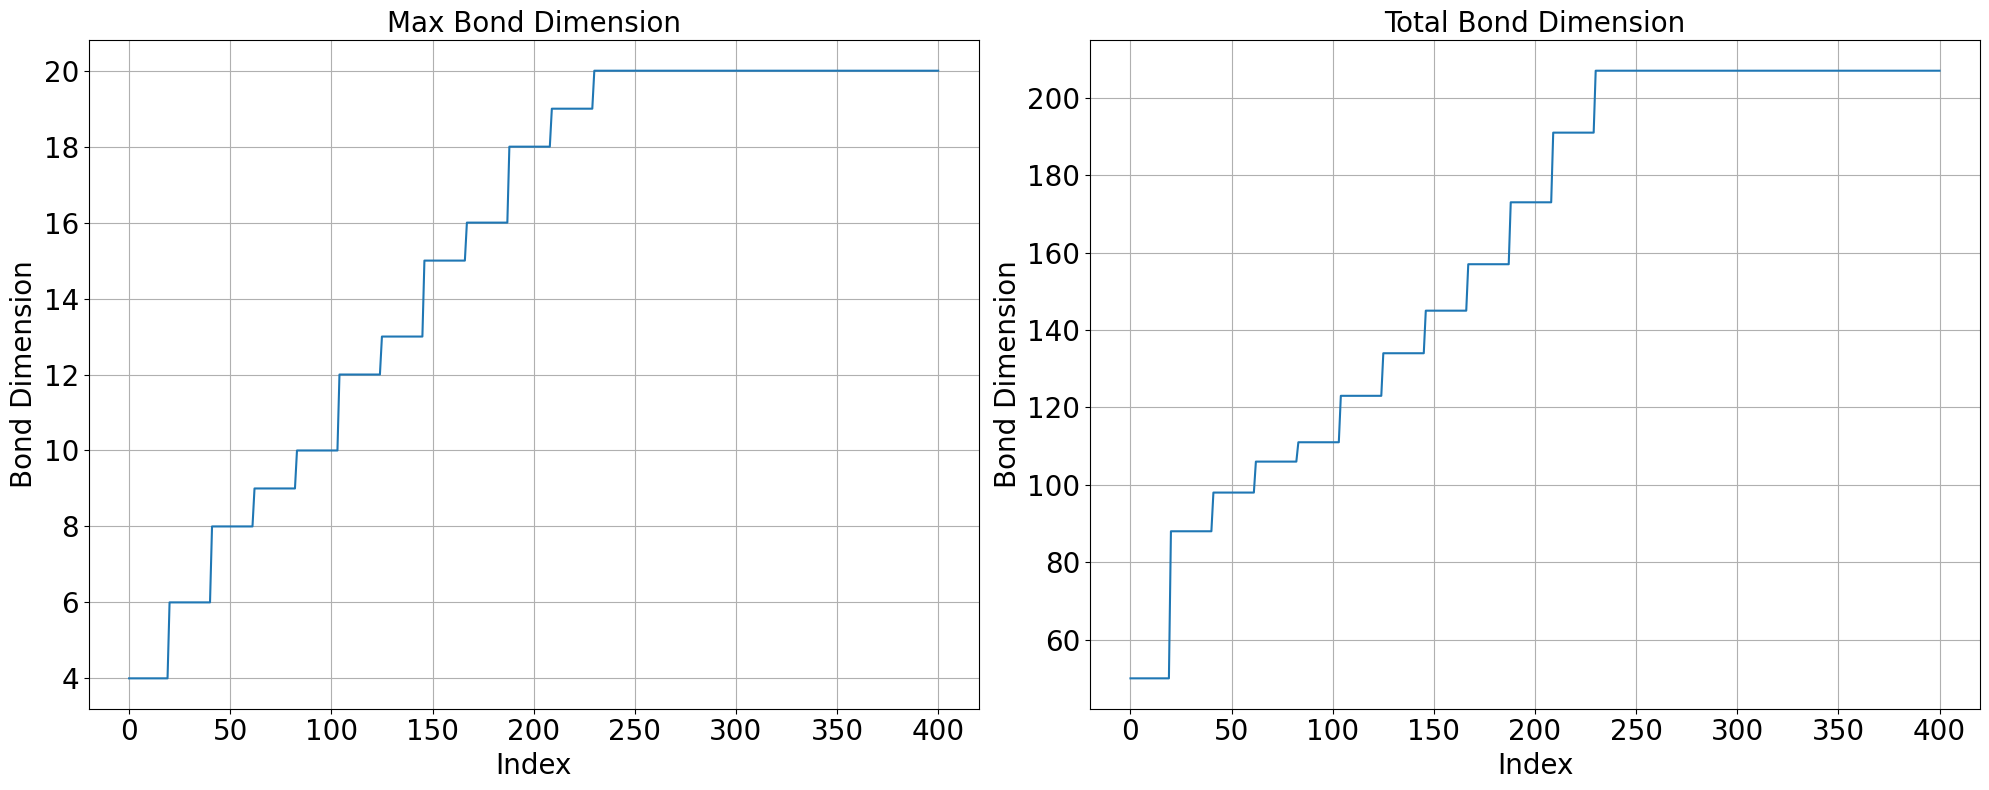

In [36]:
import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot max bond dimension
ax1.plot(tdvp_ex2.max_bond_dim)
ax1.set_title('Max Bond Dimension', fontsize=20)
ax1.set_xlabel('Index', fontsize=20)
ax1.set_ylabel('Bond Dimension', fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=20)

ax1.grid(True)

# Plot total bond dimension
ax2.plot(tdvp_ex2.total_bond_dim)
ax2.set_title('Total Bond Dimension', fontsize=20)
ax2.set_xlabel('Index', fontsize=20)
ax2.set_ylabel('Bond Dimension', fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.grid(True)


# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


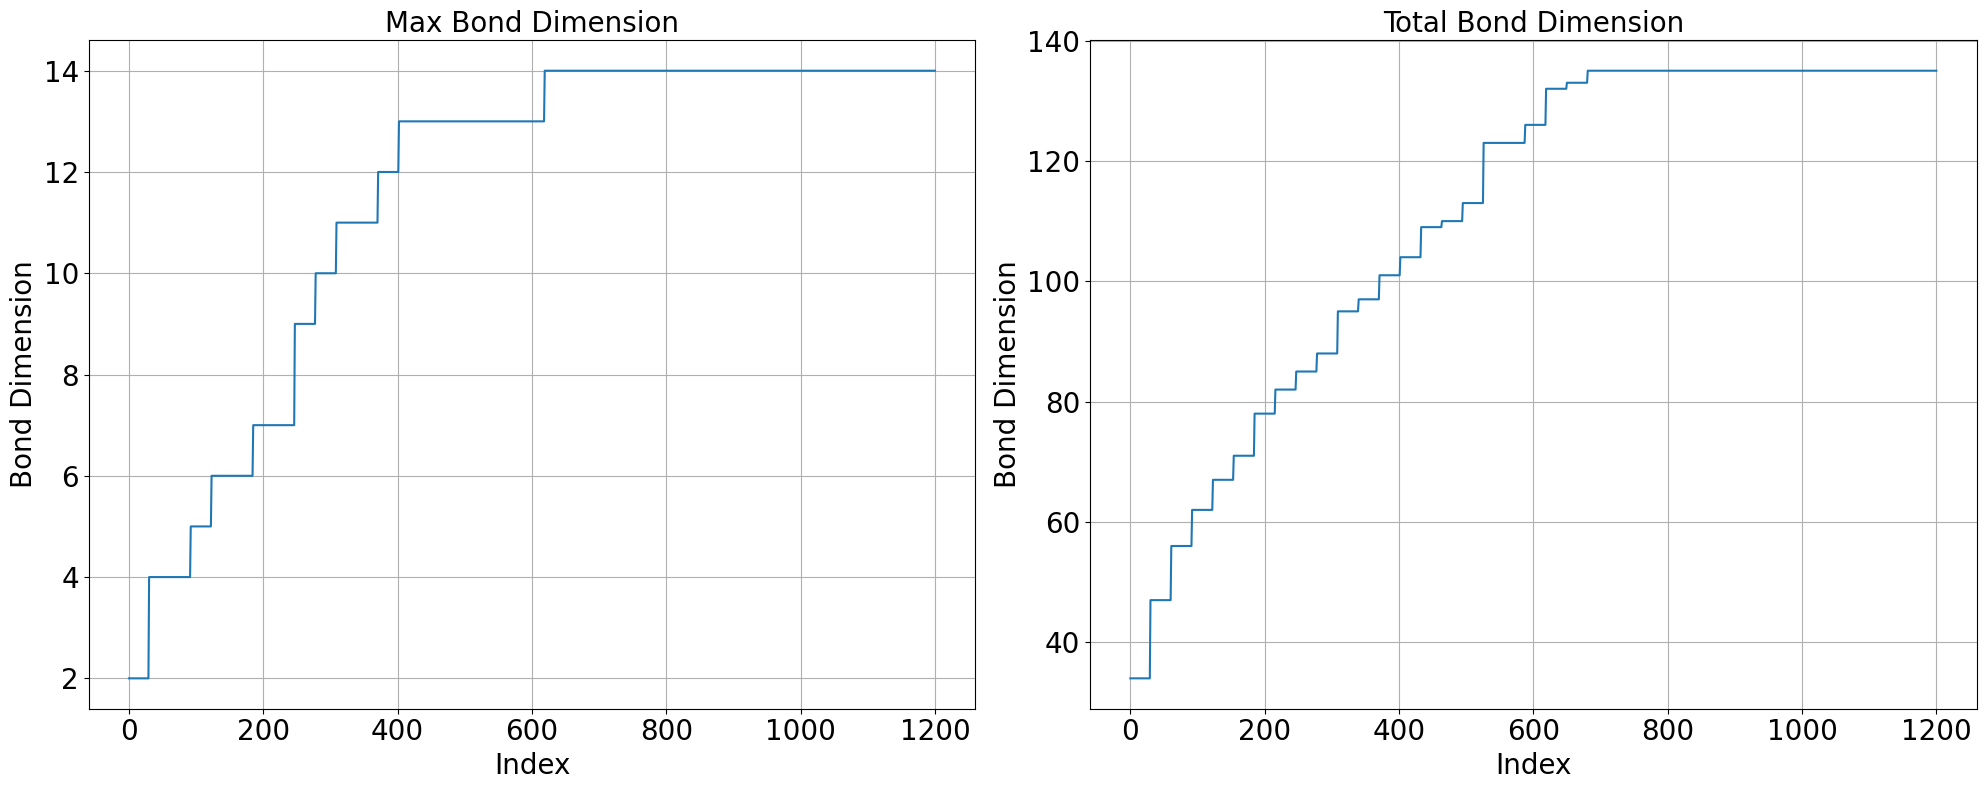

In [431]:
import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot max bond dimension
ax1.plot(tdvp_ex1.max_bond_dim)
ax1.set_title('Max Bond Dimension', fontsize=20)
ax1.set_xlabel('Index', fontsize=20)
ax1.set_ylabel('Bond Dimension', fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=20)

ax1.grid(True)

# Plot total bond dimension
ax2.plot(tdvp_ex1.total_bond_dim)
ax2.set_title('Total Bond Dimension', fontsize=20)
ax2.set_xlabel('Index', fontsize=20)
ax2.set_ylabel('Bond Dimension', fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.grid(True)


# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [24]:
X , Y , Z = ptn.pauli_matrices()
Z @ Z == Z.T @ Z.T

array([[ True,  True],
       [ True,  True]])

C:\Users\edpou\AppData\Local\Temp\ipykernel_12552\2303996310.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')  # Choose a colormap with more distinct colors


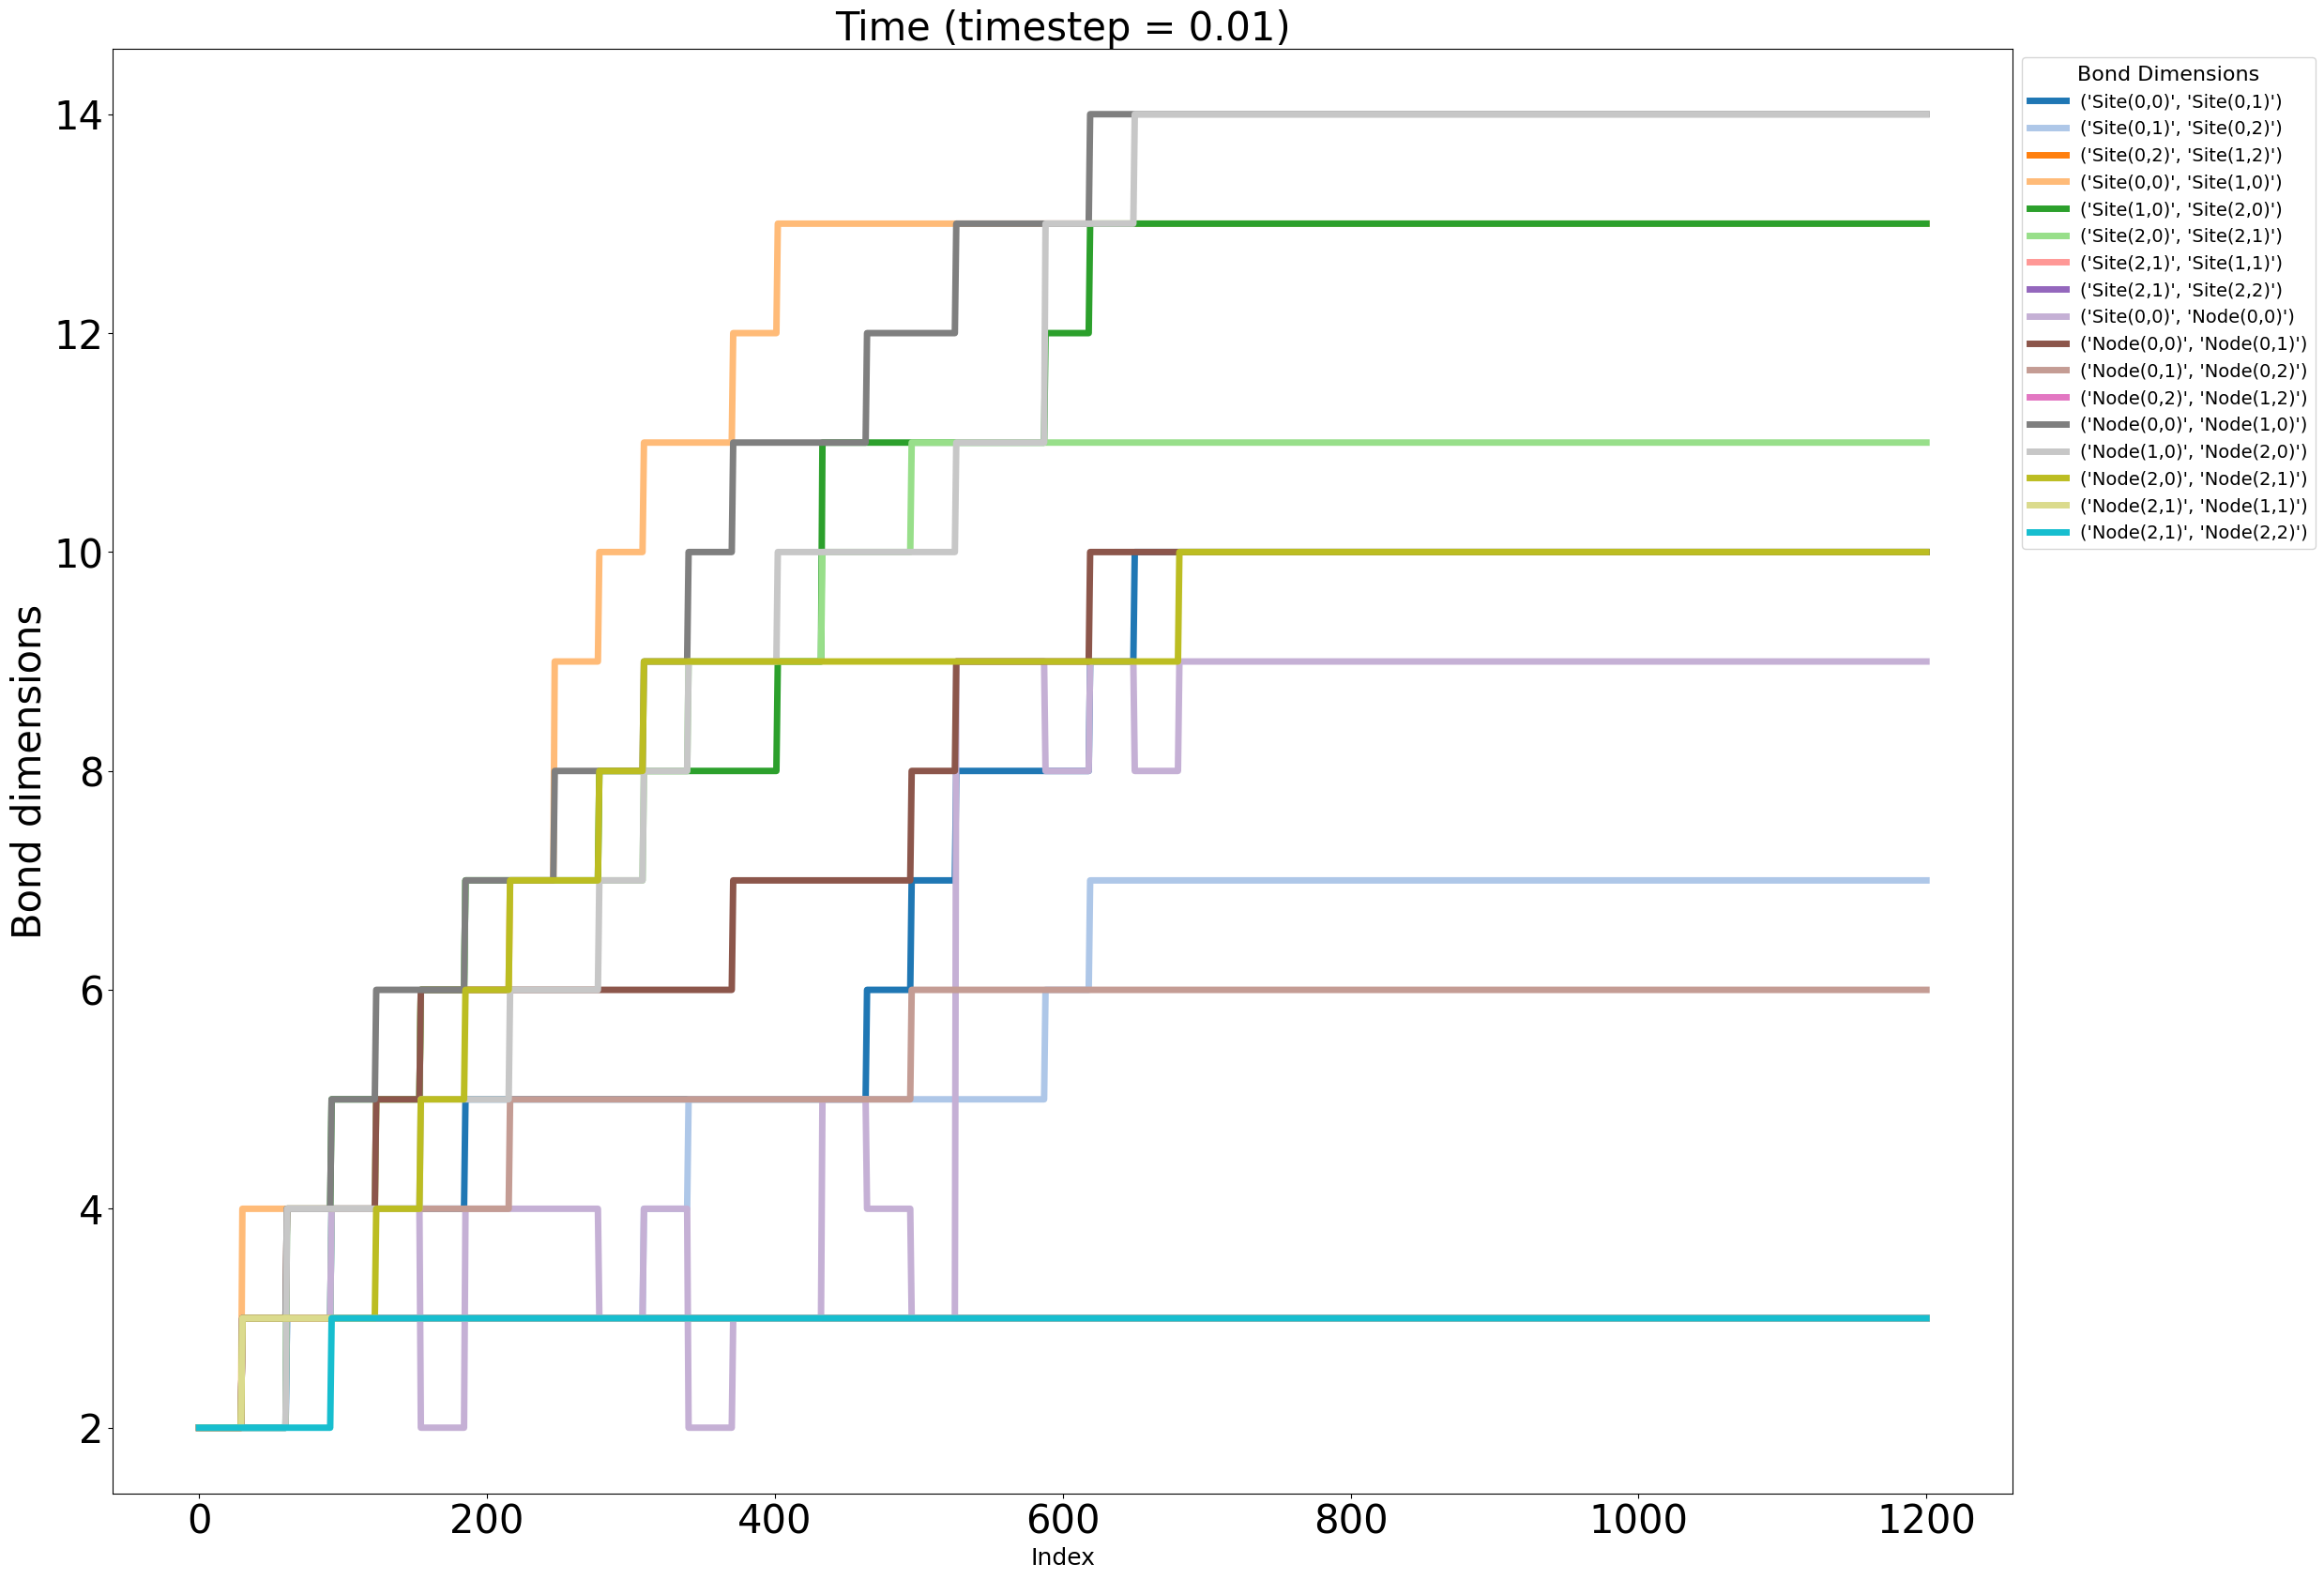

In [432]:
import matplotlib.pyplot as plt

def get_distinct_colors(n):
    """Generates a list of n distinct, visually appealing colors using colormap cyclically."""
    from matplotlib.cm import get_cmap
    cmap = get_cmap('tab20')  # Choose a colormap with more distinct colors
    return [cmap(i / n) for i in range(n)]

fig, ax = plt.subplots(figsize=(30, 20))

# Get distinct colors
colors = get_distinct_colors(len(tdvp_ex1.bond_dims))

# Plot each bond dimension with its corresponding color
for i, (key, values) in enumerate(tdvp_ex1.bond_dims.items()):
    x = list(range(len(values)))
    ax.plot(x, values, label=key, color=colors[i], linewidth=5)  # Increased linewidth for better visibility

# Customize the legend for better readability
legend = ax.legend(title='Bond Dimensions', loc='upper left', bbox_to_anchor=(1, 1), fontsize=14, title_fontsize=16)

# Customize plot labels and title
ax.set_xlabel('Index', fontsize=18)
ax.set_ylabel('Bond dimensions', fontsize=30)
ax.set_title('Time (timestep = 0.01)', fontsize=30)

# Change font size for tick labels on x and y axes
ax.tick_params(axis='both', which='major', labelsize=30)

# Increase the space for the legend
plt.subplots_adjust(right=0.8)  # Adjusts the right margin to fit the large legend

plt.show()

In [31]:
times = tdvp_ex1.times()
results_N = tdvp_ex1.operator_results()[0]
results_N


array([8.28351591+6.85806683e-16j, 8.37664928+1.98828585e-08j,
       8.46909216+4.21586266e-08j, 8.5608033 +6.67805018e-08j,
       8.65174211+9.36698223e-08j, 8.74186794+1.22718226e-07j,
       8.83113945+1.53790093e-07j, 8.91951382+1.86725168e-07j,
       9.00694615+2.21341412e-07j, 9.09338876+2.57437962e-07j,
       9.17879069+2.94798246e-07j, 9.26309716+3.33193193e-07j,
       0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
       0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
       0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
       0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
       0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
       0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
       0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
       0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
       0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
       0.        +0.00000000e+00j, 0.        +0.0000000

In [44]:
results_N = np.array([ 8.28351591+3.33066907e-16j,  8.37664928+1.98828581e-08j,
        8.46909216+4.21586275e-08j,  8.5608033 +6.67805024e-08j,
        8.65174211+9.36698224e-08j,  8.74186794+1.22718228e-07j,
        8.83113945+1.53790093e-07j,  8.91951382+1.86725167e-07j,
        9.00694615+2.21341410e-07j,  9.09338876+2.57437963e-07j,
        9.17879069+2.94798247e-07j,  9.26309716+3.33193193e-07j,
        9.34624929+3.72384521e-07j,  9.42818381+4.12128125e-07j,
        9.50883298+4.52177443e-07j,  9.5881247 +4.92286825e-07j,
        9.66592739+3.76015134e-06j,  9.74209801-1.12757338e-05j,
        9.81660452-4.84276445e-05j,  9.88935928-1.04716105e-04j,
        9.96027262-1.76477825e-04j, 10.02925414-2.59466322e-04j,
       10.09621375-3.49002922e-04j, 10.16106282-4.40099145e-04j,
       10.22371523-5.27572356e-04j, 10.28408857-6.06161196e-04j,
       10.34210516-6.70644767e-04j, 10.39769312-7.15960481e-04j,
       10.45078731-7.37318733e-04j, 10.50133011-7.30310746e-04j,
       10.54927218-6.91005321e-04j, 10.59457299-6.16031457e-04j,
       10.63723328-4.65267340e-04j, 10.67714805-2.74694191e-04j,
       10.71429649-4.90141848e-05j, 10.74867689+2.10207546e-04j,
       10.78029728+4.98906580e-04j, 10.80917472+8.11879245e-04j,
       10.83533475+1.14343924e-03j, 10.85881086+1.48774792e-03j,
       10.87964386+1.83902310e-03j, 10.89788117+2.19168890e-03j,
       10.91357611+2.54048865e-03j, 10.92678717+2.88056995e-03j,
       10.93757727+3.20754662e-03j, 10.94601302+3.51754045e-03j,
       10.95216403+3.80720542e-03j, 10.95610968+4.06202295e-03j,
       10.95791947+4.29507529e-03j, 10.95766163+4.51007163e-03j,
       10.95541355+4.70368370e-03j, 10.951252  +4.87401392e-03j,
       10.94525332+5.01987729e-03j, 10.93749314+5.14064638e-03j,
       10.92804613+5.23616499e-03j, 10.91698575+5.30667881e-03j,
       10.90438399+5.35277291e-03j, 10.89031126+5.37531393e-03j,
       10.87483619+5.37539665e-03j, 10.85802558+5.35429488e-03j,
       10.83994428+5.31341706e-03j, 10.82065517+5.25426643e-03j,
       10.80021911+5.17840583e-03j, 10.77866561+5.09133910e-03j,
       10.7560841 +5.00074391e-03j, 10.73253203+4.90685512e-03j,
       10.70806276+4.81083473e-03j, 10.68272759+4.71378731e-03j,
       10.65657586+4.61676008e-03j, 10.62965504+4.52073074e-03j,
       10.60201076+4.42659669e-03j, 10.57368688+4.33516694e-03j,
       10.54472557+4.24715647e-03j, 10.51516733+4.16318278e-03j,
       10.4850511 +4.08376421e-03j, 10.45441428+4.00931991e-03j,
       10.4232928 +3.94017110e-03j, 10.39172116+3.87654354e-03j,
       10.35971147+3.82384157e-03j, 10.32732041+3.78513009e-03j,
       10.29460112+3.76590572e-03j, 10.26157142+3.75728052e-03j,
       10.22825692+3.75617305e-03j, 10.19468356+3.76137053e-03j,
       10.16087654+3.77222885e-03j, 10.12686013+3.78832681e-03j,
       10.09265756+3.80934830e-03j, 10.0582911 +3.83503428e-03j,
       10.02378202+3.86516024e-03j,  9.98915063+3.89952445e-03j,
        9.95441633+3.93794094e-03j,  9.91959766+3.98023502e-03j,
        9.88471225+4.02624004e-03j,  9.84977696+4.07579497e-03j,
        9.81479922+4.10436588e-03j,  9.77980751+4.13812447e-03j,
        9.74481272+4.17690233e-03j,  9.70982846+4.22040133e-03j,
        9.67486774+4.26841068e-03j,  9.63994293+4.32073581e-03j,
        9.60506582+4.37718358e-03j,  9.57024756+4.43755817e-03j,
        9.53549877+4.50165997e-03j,  9.5008295 +4.56928559e-03j,
        9.46624929+4.64022840e-03j,  9.43176716+4.71427925e-03j,
        9.39739167+4.79122729e-03j,  9.36313089+4.87086078e-03j,
        9.32899246+4.95296800e-03j,  9.29498217+5.03762584e-03j,
        9.26110541+5.12396858e-03j,  9.22737036+5.21211543e-03j,
        9.19378324+5.30178602e-03j,  9.16034977+5.39277333e-03j,
        9.12707529+5.48487033e-03j,  9.0939648 +5.57787309e-03j,
        9.06102297+5.67158373e-03j,  9.02825421+5.76581233e-03j,
        8.99566261+5.86037813e-03j,  8.96325201+5.95511040e-03j,
        8.93102598+6.04984905e-03j,  8.89898788+6.14444506e-03j,
        8.8671408 +6.23876092e-03j,  8.83548764+6.33267083e-03j,
        8.80403106+6.42606100e-03j,  8.77277594+6.52108111e-03j,
        8.74172206+6.61475201e-03j,  8.71087171+6.70773268e-03j,
        8.68022694+6.79993978e-03j,  8.64978955+6.89132501e-03j,
        8.61956116+6.98185815e-03j,  8.58954323+7.07152049e-03j,
        8.55973705+7.16030286e-03j,  8.53014379+7.24820503e-03j,
        8.50076448+7.33523582e-03j,  8.47160003+7.42141347e-03j,
        8.44265122+7.50676597e-03j,  8.41391874+7.59133160e-03j,
        8.38540316+7.67515932e-03j,  8.35710494+7.75830926e-03j,
        8.32902331+7.83973334e-03j,  8.30116036+7.92309877e-03j,
        8.27351571+8.00635751e-03j,  8.24608926+8.08916087e-03j,
        8.21888101+8.17156023e-03j,  8.19189095+8.25365542e-03j,
        8.16511898+8.33556936e-03j,  8.13856493+8.41744393e-03j,
        8.11222857+8.49943908e-03j,  8.08610963+8.58173266e-03j,
        8.06020776+8.66452065e-03j,  8.03452254+8.74801733e-03j,
        8.00905354+8.83245565e-03j,  7.98380025+8.91808750e-03j,
        7.95876212+9.00518410e-03j,  7.93393855+9.09403633e-03j,
        7.90932918+9.18515173e-03j,  7.88493294+9.27861723e-03j,
        7.86074919+9.37488080e-03j,  7.83677718+9.47432211e-03j,
        7.81301612+9.57733766e-03j,  7.78946519+9.68434547e-03j,
        7.76612353+9.79578593e-03j,  7.74299023+9.91212223e-03j,
        7.72006438+1.00338406e-02j,  7.69734502+1.01614508e-02j,
        7.67483116+1.02954859e-02j,  7.65252179+1.04365031e-02j,
        7.63041586+1.05850836e-02j,  7.60851231+1.07418329e-02j,
        7.58681005+1.09073808e-02j,  7.56530793+1.10821695e-02j,
        7.54400448+1.12672668e-02j,  7.5228988 +1.14633720e-02j,
        7.50198975+1.16710883e-02j,  7.48127612+1.18911505e-02j,
        7.46075668+1.21243275e-02j,  7.44043018+1.23714145e-02j,
        7.42029534+1.26332318e-02j,  7.40035086+1.29106245e-02j,
        7.38059542+1.32044622e-02j,  7.36102769+1.35156390e-02j,
        7.3416463 +1.38450734e-02j,  7.32244988+1.41937076e-02j,
        7.30343702+1.45625079e-02j,  7.28460632+1.49524639e-02j,
        7.26595632+1.53645883e-02j,  7.24748548+1.57985367e-02j,
        7.22919249+1.62563900e-02j,  7.21107571+1.67395956e-02j,
        7.19313362+1.72492323e-02j,  7.17536468+1.77863946e-02j,
        7.15776735+1.83521957e-02j,  7.14034006+1.89477670e-02j,
        7.12308121+1.95742581e-02j,  7.10598921+2.02328349e-02j,
        7.08906245+2.09246793e-02j,  7.07229928+2.16509878e-02j,
        7.05569806+2.24129704e-02j,  7.03925713+2.32118492e-02j,
        7.02297482+2.40488577e-02j,  7.00684943+2.49252389e-02j,
        6.99087927+2.58423643e-02j,  6.97506261+2.68017779e-02j,
        6.95939784+2.78042248e-02j,  6.94388311+2.88509586e-02j,
        6.92851661+2.99432684e-02j,  6.91329656+3.10824406e-02j,
        6.89822119+3.22697577e-02j,  6.88328871+3.35064989e-02j,
        6.86849733+3.47939387e-02j,  6.85384526+3.61333465e-02j,
        6.8393307 +3.75259851e-02j,  6.82495184+3.89731092e-02j,
        6.81070686+4.04759645e-02j,  6.79659395+4.20357859e-02j,
        6.78261129+4.36537959e-02j,  6.76875706+4.53312036e-02j,
        6.75502891+4.70692531e-02j,  6.74142533+4.88693992e-02j,
        6.72794471+5.07325667e-02j,  6.71458526+5.26598386e-02j,
        6.70134517+5.46523077e-02j,  6.68822263+5.67110533e-02j,
        6.67521584+5.88371342e-02j,  6.66232301+6.10315865e-02j,
        6.64954236+6.32954208e-02j,  6.63687212+6.56296209e-02j,
        6.62431055+6.80351424e-02j,  6.6118559 +7.05129115e-02j,
        6.59950646+7.30638233e-02j,  6.58726053+7.56887412e-02j,
        6.57511644+7.83884954e-02j,  6.56307253+8.11638493e-02j,
        6.55112716+8.40155811e-02j,  6.53927874+8.69444560e-02j,
        6.52752572+8.99511524e-02j,  6.51586657+9.30363141e-02j,
        6.50429981+9.62005494e-02j,  6.49282397+9.94444290e-02j,
        6.48143764+1.02768485e-01j,  6.47013943+1.06173210e-01j,
        6.45892802+1.09659055e-01j,  6.44780212+1.13226431e-01j,
        6.43676051+1.16875708e-01j,  6.425802  +1.20607212e-01j,
        6.41492545+1.24421227e-01j,  6.40412981+1.28317995e-01j,
        6.39341405+1.32297714e-01j,  6.38277725+1.36359964e-01j,
        6.37221853+1.40505399e-01j,  6.36173701+1.44733993e-01j,
        6.35133192+1.49045757e-01j,  6.34100256+1.53440661e-01j,
        6.3307483 +1.57918633e-01j,  6.32056859+1.62479559e-01j,
        6.31046295+1.67123276e-01j,  6.30043097+1.71849579e-01j,
        6.29047235+1.76658215e-01j,  6.28058683+1.81548885e-01j,
        6.27077428+1.86521245e-01j,  6.26103463+1.91574902e-01j,
        6.25136788+1.96709417e-01j,  6.24177415+2.01924299e-01j,
        6.23225363+2.07219008e-01j,  6.22280661+2.12592952e-01j,
        6.21343346+2.18045499e-01j,  6.20413467+2.23575959e-01j,
        6.1949108 +2.29183587e-01j,  6.1857625 +2.34867584e-01j,
        6.17669053+2.40627094e-01j,  6.16769574+2.46461203e-01j,
        6.15877907+2.52368939e-01j,  6.14994156+2.58349267e-01j,
        6.14118433+2.64401088e-01j,  6.13250862+2.70523238e-01j,
        6.12391575+2.76714485e-01j,  6.11540712+2.82973526e-01j,
        6.10698424+2.89298982e-01j,  6.0986487 +2.95689400e-01j,
        6.09040218+3.02143279e-01j,  6.08224645+3.08658996e-01j,
        6.07418337+3.15234830e-01j,  6.06621487+3.21868987e-01j,
        6.05834295+3.28559577e-01j,  6.05056969+3.35304616e-01j,
        6.04289727+3.42102013e-01j,  6.03532788+3.48949572e-01j,
        6.02786383+3.55844988e-01j,  6.02050745+3.62785838e-01j,
        6.01326112+3.69769580e-01j,  6.0061273 +3.76793548e-01j,
        5.99910844+3.83854946e-01j,  5.99220706+3.90950846e-01j,
        5.98542568+3.98078181e-01j,  5.97876687+4.05233716e-01j,
        5.97223312+4.12414090e-01j,  5.96582698+4.19615845e-01j,
        5.95955102+4.26835321e-01j,  5.95340774+4.34068702e-01j,
        5.94739964+4.41312010e-01j,  5.94152913+4.48561106e-01j,
        5.93579859+4.55811687e-01j,  5.93021033+4.63059285e-01j,
        5.92476655+4.70299263e-01j,  5.91946938+4.77526818e-01j,
        5.91432082+4.84736982e-01j,  5.90932274+4.91924618e-01j,
        5.90447687+4.99084430e-01j,  5.8997848 +5.06210958e-01j,
        5.89524791+5.13298590e-01j,  5.89086743+5.20341560e-01j,
        5.88664434+5.27333960e-01j,  5.88257943+5.34269746e-01j,
        5.87867325+5.41142746e-01j,  5.87492606+5.47946671e-01j,
        5.87133789+5.54675127e-01j,  5.86790846+5.61321626e-01j,
        5.8646372 +5.67879606e-01j,  5.86152321+5.74342440e-01j,
        5.85856527+5.80703457e-01j,  5.85576183+5.86955962e-01j,
        5.85311096+5.93093252e-01j,  5.85061041+5.99108639e-01j,
        5.8482575 +6.04995476e-01j,  5.84604923+6.10747175e-01j,
        5.84404142+6.16426087e-01j,  5.84223727+6.22039465e-01j,
        5.84056637+6.27490919e-01j,  5.83902463+6.32774644e-01j,
        5.83760747+6.37884937e-01j,  5.83630981+6.42816167e-01j,
        5.83512618+6.47562831e-01j,  5.83405073+6.52119587e-01j,
        5.83307718+6.56481285e-01j,  5.83219891+6.60642995e-01j,
        5.83140894+6.64600044e-01j,  5.83069994+6.68348042e-01j,
        5.83006426+6.71882927e-01j,  5.82949395+6.75200995e-01j,
        5.82898079+6.78298940e-01j,  5.82851633+6.81173886e-01j,
        5.82809188+6.83823415e-01j,  5.82769859+6.86245600e-01j,
        5.82732749+6.88439016e-01j,  5.82696946+6.90402764e-01j,
        5.82661535+6.92136476e-01j,  5.82625596+6.93640325e-01j,
        5.82588212+6.94915023e-01j,  5.82548471+6.95961822e-01j,
        5.82505467+6.96782508e-01j,  5.8245831 +6.97379389e-01j,
        5.82406125+6.97755285e-01j,  5.82348057+6.97913515e-01j,
        5.82283273+6.97857871e-01j,  5.8221097 +6.97592609e-01j,
        5.8213037 +6.97122416e-01j,  5.8204073 +6.96452391e-01j,
        5.81941341+6.95588016e-01j,  5.81831533+6.94535129e-01j,
        5.81710672+6.93299894e-01j,  5.81578166+6.91888771e-01j,
        5.81433467+6.90308483e-01j,  5.81276069+6.88565986e-01j,
        5.81105511+6.86668436e-01j,  5.80921377+6.84623155e-01j,
        5.80723298+6.82437603e-01j,  5.80510947+6.80119344e-01j,
        5.80284047+6.77676012e-01j,  5.80042363+6.75115289e-01j,
        5.79785706+6.72444868e-01j,  5.79513932+6.69672429e-01j,
        5.79226937+6.66805614e-01j,  5.7892466 +6.63851997e-01j,
        5.78607081+6.60819065e-01j,  5.7827422 +6.57714198e-01j,
        5.77926131+6.54544640e-01j,  5.77562907+6.51317492e-01j,
        5.77184673+6.48039686e-01j,  5.76791587+6.44717976e-01j,
        5.76383839+6.41358923e-01j,  5.75961645+6.37968882e-01j,
        5.75525249+6.34553994e-01j,  5.7507492 +6.31120177e-01j,
        5.74610949+6.27673120e-01j,  5.7413365 +6.24218275e-01j,
        5.73643354+6.20760859e-01j,  5.73140412+6.17305843e-01j,
        5.72625188+6.13857958e-01j,  5.72098063+6.10421690e-01j,
        5.71559429+6.07001283e-01j,  5.71009689+6.03600739e-01j,
        5.70449258+6.00223821e-01j,  5.69878555+5.96874057e-01j,
        5.6929801 +5.93554742e-01j,  5.68708057+5.90268943e-01j,
        5.68109134+5.87019504e-01j,  5.67501683+5.83809054e-01j,
        5.6688615 +5.80640005e-01j,  5.66262979+5.77514566e-01j,
        5.65632619+5.74434744e-01j,  5.64995516+5.71402354e-01j,
        5.64352117+5.68419021e-01j,  5.63702865+5.65486190e-01j,
        5.63048203+5.62605129e-01j,  5.62388572+5.59776940e-01j,
        5.61724409+5.57002561e-01j,  5.61056146+5.54282774e-01j,
        5.60384215+5.51618211e-01j,  5.59709041+5.49009360e-01j,
        5.59031044+5.46456569e-01j,  5.58350642+5.43960056e-01j,
        5.57668246+5.41519909e-01j,  5.56984264+5.39136095e-01j,
        5.56299095+5.36808463e-01j,  5.55613138+5.34536751e-01j,
        5.54926782+5.32320586e-01j,  5.54240413+5.30159494e-01j,
        5.53554411+5.28052899e-01j,  5.52869151+5.26000132e-01j,
        5.52185   +5.24000429e-01j,  5.51502323+5.22052939e-01j,
        5.50821477+5.20156724e-01j,  5.50142815+5.18310765e-01j,
        5.49466682+5.16513961e-01j,  5.48793421+5.14765136e-01j,
        5.48123366+5.13063038e-01j,  5.47456848+5.11406344e-01j,
        5.46794192+5.09793658e-01j,  5.46135716+5.08223519e-01j,
        5.45481736+5.06694398e-01j,  5.44832558+5.05204700e-01j,
        5.44188486+5.03752770e-01j,  5.43549819+5.02336889e-01j,
        5.42916847+5.00955280e-01j,  5.42289858+4.99606106e-01j,
        5.41669132+4.98287474e-01j,  5.41054947+4.96997436e-01j,
        5.40447571+4.95733988e-01j,  5.3984727 +4.94495075e-01j,
        5.39254303+4.93278588e-01j,  5.38668923+4.92082369e-01j,
        5.38091377+4.90904213e-01j,  5.37521907+4.89741865e-01j,
        5.36960748+4.88593026e-01j,  5.36408131+4.87455353e-01j,
        5.35864277+4.86326459e-01j,  5.35329404+4.85203920e-01j,
        5.34803723+4.84085269e-01j,  5.34287436+4.82968007e-01j,
        5.33780741+4.81849598e-01j,  5.33283828+4.80727476e-01j,
        5.3279688 +4.79599044e-01j,  5.32320072+4.78461680e-01j,
        5.31853572+4.77312739e-01j,  5.3139754 +4.76149555e-01j,
        5.30952131+4.74969444e-01j,  5.30517487+4.73769711e-01j,
        5.30093746+4.72547649e-01j,  5.29681036+4.71300548e-01j,
        5.29279477+4.70025693e-01j,  5.2888918 +4.68720376e-01j,
        5.28510248+4.67381893e-01j,  5.28142773+4.66007557e-01j,
        5.2778684 +4.64594694e-01j,  5.27442524+4.63140656e-01j,
        5.27109891+4.61642824e-01j,  5.26788997+4.60098612e-01j,
        5.26479889+4.58505476e-01j,  5.26182603+4.56860918e-01j,
        5.25897167+4.55162493e-01j,  5.256236  +4.53407817e-01j,
        5.25361907+4.51594572e-01j,  5.25112088+4.49720513e-01j,
        5.2487413 +4.47783476e-01j,  5.24648012+4.45781385e-01j,
        5.24433702+4.43712258e-01j,  5.24231159+4.41574216e-01j,
        5.24040333+4.39365491e-01j,  5.23861162+4.37084429e-01j,
        5.23693579+4.34729503e-01j,  5.23537502+4.32299316e-01j,
        5.23392846+4.29792613e-01j,  5.23259511+4.27208281e-01j,
        5.23137393+4.24545364e-01j,  5.23026377+4.21803065e-01j,
        5.22926341+4.18980755e-01j,  5.22837153+4.16077978e-01j,
        5.22758675+4.13094459e-01j,  5.22690761+4.10030109e-01j,
        5.22633255+4.06885031e-01j,  5.22585998+4.03659525e-01j,
        5.2254882 +4.00354095e-01j,  5.22521548+3.96969452e-01j,
        5.22503999+3.93506518e-01j,  5.22495985+3.89966433e-01j,
        5.22497313+3.86350553e-01j,  5.22507784+3.82660457e-01j,
        5.2252719 +3.78897951e-01j,  5.22555321+3.75065064e-01j,
        5.2259196 +3.71164053e-01j,  5.22636884+3.67197406e-01j,
        5.22689867+3.63167837e-01j,  5.22750674+3.59078288e-01j,
        5.22819067+3.54931928e-01j,  5.22894802+3.50732153e-01j,
        5.2297763 +3.46482578e-01j,  5.23067295+3.42187040e-01j,
        5.23163536+3.37849590e-01j,  5.23266086+3.33474491e-01j,
        5.23374672+3.29066210e-01j,  5.23489014+3.24629416e-01j,
        5.23608824+3.20168968e-01j,  5.23733809+3.15689913e-01j,
        5.23863666+3.11197475e-01j,  5.23998086+3.06697046e-01j,
        5.24136748+3.02194177e-01j,  5.24279327+2.97694567e-01j,
        5.24425483+2.93204056e-01j,  5.2457487 +2.88728606e-01j,
        5.24727128+2.84274297e-01j,  5.24881889+2.79847307e-01j,
        5.25038771+2.75453904e-01j,  5.2519738 +2.71100428e-01j,
        5.25357309+2.66793280e-01j,  5.25518137+2.62538902e-01j,
        5.25679432+2.58343768e-01j,  5.25840743+2.54214361e-01j,
        5.26001608+2.50157164e-01j,  5.26161547+2.46178636e-01j,
        5.26320067+2.42285202e-01j,  5.26476657+2.38483232e-01j,
        5.26630791+2.34779024e-01j,  5.26781927+2.31178789e-01j,
        5.26929506+2.27688633e-01j,  5.27072953+2.24314540e-01j,
        5.27211678+2.21062357e-01j,  5.27345073+2.17937777e-01j,
        5.27472517+2.14946321e-01j,  5.27593371+2.12093328e-01j,
        5.27706983+2.09383937e-01j,  5.27812687+2.06823076e-01j,
        5.27909803+2.04415447e-01j,  5.27997638+2.02165516e-01j,
        5.28075487+2.00077501e-01j,  5.28142636+1.98155366e-01j,
        5.28198359+1.96402810e-01j,  5.28241921+1.94823263e-01j,
        5.28272581+1.93419879e-01j,  5.28289591+1.92195532e-01j,
        5.28292196+1.91152819e-01j,  5.28279639+1.90294054e-01j,
        5.2825116 +1.89621274e-01j,  5.28205996+1.89136241e-01j,
        5.28143386+1.88840447e-01j,  5.28062568+1.88735123e-01j,
        5.27962783+1.88821244e-01j,  5.27843277+1.89099548e-01j,
        5.27703298+1.89570539e-01j,  5.27542102+1.90234508e-01j,
        5.27358948+1.91091551e-01j,  5.27153107+1.92141581e-01j,
        5.26923855+1.93384351e-01j,  5.26670477+1.94819480e-01j,
        5.26392268+1.96446467e-01j,  5.26088532+1.98264725e-01j,
        5.25758582+2.00273602e-01j,  5.25401741+2.02472410e-01j,
        5.25017343+2.04860456e-01j,  5.24604727+2.07437067e-01j,
        5.24163244+2.10201629e-01j,  5.23692251+2.13153614e-01j,
        5.23191112+2.16292619e-01j,  5.22659197+2.19618396e-01j,
        5.22095879+2.23130893e-01j,  5.21500533+2.26830290e-01j,
        5.20872536+2.30717037e-01j,  5.20211263+2.34791897e-01j,
        5.19516086+2.39055984e-01j,  5.18786369+2.43510809e-01j,
        5.18021469+2.48158326e-01j,  5.17220731+2.53000974e-01j,
        5.16383483+2.58041730e-01j,  5.15509036+2.63284159e-01j,
        5.1459668 +2.68732466e-01j,  5.13645678+2.74391554e-01j,
        5.12655262+2.80267085e-01j,  5.11624632+2.86365543e-01j,
        5.10552945+2.92694301e-01j,  5.09439317+2.99261695e-01j,
        5.08282813+3.06077106e-01j,  5.07082444+3.13151040e-01j,
        5.05837159+3.20495226e-01j,  5.0454584 +3.28122714e-01j,
        5.03207295+3.36047989e-01j,  5.0182025 +3.44287092e-01j,
        5.00383344+3.52857754e-01j,  4.9889512 +3.61779546e-01j,
        4.97354014+3.71074048e-01j,  4.95758351+3.80765029e-01j,
        4.9410633 +3.90878653e-01j])

In [21]:
results_N00 = np.array([8.28351591+3.33066907e-16j, 8.28353844-1.02730720e-09j,
       8.28356133-2.05073201e-09j, 8.2835846 -3.07006860e-09j,
       8.28360823-4.08510874e-09j, 8.28363223-5.09564063e-09j,
       8.2836566 -6.10146256e-09j, 8.28368135-7.10236447e-09j,
       8.28370647-8.09814089e-09j, 8.28373197-9.08858295e-09j,
       8.28375785-1.00734919e-08j, 8.28378411-1.10526607e-08j,
       8.28381075-1.20258840e-08j, 8.28383777-1.29929626e-08j,
       8.28386518-1.39536941e-08j, 8.28389297-1.49078810e-08j,
       8.2839089 +8.73772899e-06j, 8.28389246+2.20943122e-05j,
       8.28387399+3.27461150e-05j, 8.28385466+4.26253408e-05j,
       8.28383473+5.22395254e-05j, 8.28381428+6.17944034e-05j,
       8.28379336+7.13891683e-05j, 8.283772  +8.10752187e-05j,
       8.28375022+9.08792172e-05j, 8.28372803+1.00813743e-04j,
       8.28370544+1.10882798e-04j, 8.28368247+1.21084888e-04j,
       8.28365913+1.31414871e-04j, 8.28363542+1.41865106e-04j,
       8.28361137+1.52426214e-04j, 8.28358698+1.63087585e-04j,
       8.28356429+1.68495458e-04j, 8.28353892+1.74768924e-04j,
       8.28351528+1.80907938e-04j, 8.28349308+1.86880543e-04j,
       8.28347224+1.92738518e-04j, 8.28345274+1.98528633e-04j,
       8.28343456+2.04287381e-04j, 8.28341769+2.10043091e-04j,
       8.28340213+2.15818172e-04j, 8.28338787+2.21630747e-04j,
       8.28337489+2.27495801e-04j, 8.28336321+2.33425976e-04j,
       8.2833528 +2.39432133e-04j, 8.28334367+2.45523762e-04j,
       8.2833358 +2.51709276e-04j, 8.28332248+2.67054573e-04j,
       8.28329855+2.90417162e-04j, 8.28327264+3.13340856e-04j,
       8.28324552+3.36086311e-04j, 8.28321735+3.58745642e-04j,
       8.28318818+3.81364969e-04j, 8.28315801+4.03972663e-04j,
       8.28312686+4.26588313e-04j, 8.28309475+4.49226405e-04j,
       8.28306167+4.71898120e-04j, 8.28302763+4.94612313e-04j,
       8.28299263+5.17376102e-04j, 8.28295668+5.40195242e-04j,
       8.28291978+5.63074383e-04j, 8.28288195+5.86017247e-04j,
       8.28284317+6.09026762e-04j, 8.28280813+6.29790843e-04j,
       8.28276757+6.49727842e-04j, 8.28272472+6.70784602e-04j,
       8.28268058+6.92701966e-04j, 8.28263561+7.15325585e-04j,
       8.28259007+7.38549583e-04j, 8.28254412+7.62293176e-04j,
       8.28249788+7.86489567e-04j, 8.28245143+8.11080157e-04j,
       8.28240482+8.36011349e-04j, 8.2823581 +8.61232749e-04j,
       8.28231131+8.86696142e-04j, 8.28226445+9.12354941e-04j,
       8.28221755+9.38163915e-04j, 8.28217063+9.64079092e-04j,
       8.28213228+9.73900335e-04j, 8.28210372+9.69516683e-04j,
       8.28207458+9.65424100e-04j, 8.28204534+9.61080325e-04j,
       8.28201624+9.56283410e-04j, 8.28198743+9.50921317e-04j,
       8.28195899+9.44924544e-04j, 8.28193099+9.38250424e-04j,
       8.28190348+9.30875738e-04j, 8.28187648+9.22792120e-04j,
       8.28185001+9.14002638e-04j, 8.28182405+9.04519003e-04j,
       8.28179859+8.94359264e-04j, 8.28177361+8.83545894e-04j,
       8.28174908+8.72104267e-04j, 8.28172495+8.60061453e-04j,
       8.28172477+8.50123725e-04j, 8.28172806+8.39427662e-04j,
       8.2817332 +8.28350740e-04j, 8.28173974+8.17028751e-04j,
       8.2817475 +8.05517509e-04j, 8.28175633+7.93845279e-04j,
       8.28176614+7.82027085e-04j, 8.28177684+7.70070360e-04j,
       8.28178839+7.57977736e-04j, 8.28180071+7.45748630e-04j,
       8.28181375+7.33380219e-04j, 8.28182748+7.20868094e-04j,
       8.28184185+7.08206703e-04j, 8.28185682+6.95389674e-04j,
       8.28187236+6.82410045e-04j, 8.28188782+6.68581680e-04j,
       8.28190445+6.53326638e-04j, 8.28192003+6.37008045e-04j,
       8.28193437+6.19872969e-04j, 8.28194738+6.01995509e-04j,
       8.28195902+5.83408934e-04j, 8.28196924+5.64130619e-04j,
       8.281978  +5.44170332e-04j, 8.28198526+5.23533859e-04j,
       8.28199099+5.02224857e-04j, 8.28199516+4.80245898e-04j,
       8.28199773+4.57599075e-04j, 8.28199865+4.34286368e-04j,
       8.28199791+4.10309854e-04j, 8.28199546+3.85671828e-04j,
       8.28199128+3.60374867e-04j, 8.28197812+3.39704428e-04j,
       8.28195999+3.18419186e-04j, 8.28193941+2.96668282e-04j,
       8.28191656+2.74498327e-04j, 8.28189147+2.51920974e-04j,
       8.28186415+2.28939114e-04j, 8.28183456+2.05552876e-04j,
       8.28180268+1.81761526e-04j, 8.28176848+1.57564167e-04j,
       8.28173191+1.32960001e-04j, 8.28169294+1.07948421e-04j,
       8.28165153+8.25290266e-05j, 8.28160766+5.67016054e-05j,
       8.28156128+3.04661094e-05j, 8.28151235+3.82262114e-06j,
       8.28145126-2.29316332e-05j, 8.28137008-5.00322530e-05j,
       8.28128431-7.78404551e-05j, 8.28119471-1.06206317e-04j,
       8.28110148-1.35045078e-04j, 8.28100472-1.64307990e-04j,
       8.28090447-1.93963787e-04j, 8.28080079-2.23990881e-04j,
       8.28069369-2.54373567e-04j, 8.28058321-2.85099967e-04j,
       8.28046936-3.16160812e-04j, 8.28035217-3.47548680e-04j,
       8.28023166-3.79257498e-04j, 8.28010784-4.11282206e-04j,
       8.27998072-4.43618516e-04j, 8.27985033-4.76262752e-04j,
       8.27974955-5.17908697e-04j, 8.27965471-5.58436579e-04j,
       8.27955929-5.97776038e-04j, 8.27946265-6.36435656e-04j,
       8.2793646 -6.74626228e-04j, 8.27926509-7.12457332e-04j,
       8.27916409-7.49993871e-04j, 8.27906159-7.87277637e-04j,
       8.2789576 -8.24337126e-04j, 8.27885212-8.61192577e-04j,
       8.27874516-8.97858793e-04j, 8.27863674-9.34346823e-04j,
       8.27852686-9.70665033e-04j, 8.27841553-1.00681980e-03j,
       8.27830278-1.04281597e-03j, 8.27820091-1.07833142e-03j,
       8.27812171-1.10944243e-03j, 8.27804556-1.13924491e-03j,
       8.27797013-1.16839675e-03j, 8.27789469-1.19713912e-03j,
       8.2778189 -1.22559395e-03j, 8.27774257-1.25383382e-03j,
       8.27766559-1.28190644e-03j, 8.27758786-1.30984538e-03j,
       8.27750934-1.33767540e-03j, 8.27742998-1.36541537e-03j,
       8.27734977-1.39308006e-03j, 8.27726867-1.42068121e-03j,
       8.27718667-1.44822828e-03j, 8.27710375-1.47572892e-03j,
       8.27701992-1.50318936e-03j, 8.2769328 -1.52994008e-03j,
       8.27684233-1.55318563e-03j, 8.27674908-1.57556085e-03j,
       8.27665319-1.59751987e-03j, 8.27655471-1.61920819e-03j,
       8.27645368-1.64069364e-03j, 8.27635011-1.66201486e-03j,
       8.27624401-1.68319683e-03j, 8.27613537-1.70425712e-03j,
       8.27602421-1.72520883e-03j, 8.27591051-1.74606215e-03j,
       8.27579429-1.76682522e-03j, 8.27567552-1.78750470e-03j,
       8.27555421-1.80810606e-03j, 8.27543036-1.82863384e-03j,
       8.27530594-1.84856727e-03j, 8.27518087-1.86811779e-03j,
       8.27505337-1.88748552e-03j, 8.27492337-1.90663777e-03j,
       8.27479086-1.92556839e-03j, 8.27465582-1.94427506e-03j,
       8.27451824-1.96275703e-03j, 8.2743781 -1.98101425e-03j,
       8.27423539-1.99904700e-03j, 8.27409011-2.01685563e-03j,
       8.27394225-2.03444045e-03j, 8.2737918 -2.05180162e-03j,
       8.27363874-2.06893911e-03j, 8.27348307-2.08585267e-03j,
       8.27332479-2.10254181e-03j, 8.27316387-2.11900578e-03j,
       8.27301059-2.13873472e-03j, 8.2728579 -2.15797982e-03j,
       8.27270327-2.17707544e-03j, 8.27254651-2.19604285e-03j,
       8.27238757-2.21489040e-03j, 8.27222644-2.23362206e-03j,
       8.27206309-2.25223974e-03j, 8.27189752-2.27074421e-03j,
       8.27172973-2.28913553e-03j, 8.27155971-2.30741324e-03j,
       8.27138745-2.32557651e-03j, 8.27121296-2.34362423e-03j,
       8.27103622-2.36155501e-03j, 8.27085724-2.37936728e-03j,
       8.27067601-2.39705926e-03j, 8.2705199 -2.40631990e-03j,
       8.27039758-2.40386158e-03j, 8.27027356-2.39987086e-03j,
       8.27014763-2.39501877e-03j, 8.27001983-2.38952076e-03j,
       8.2698902 -2.38348182e-03j, 8.26975877-2.37696355e-03j,
       8.26962556-2.37000628e-03j, 8.2694906 -2.36263838e-03j,
       8.2693539 -2.35488082e-03j, 8.26921547-2.34674968e-03j,
       8.26907534-2.33825761e-03j, 8.2689335 -2.32941476e-03j,
       8.26878998-2.32022937e-03j, 8.26864477-2.31070822e-03j,
       8.26849788-2.30085684e-03j, 8.26841041-2.28684568e-03j,
       8.26833465-2.27379443e-03j, 8.26826027-2.26119288e-03j,
       8.26818633-2.24877207e-03j, 8.26811247-2.23640504e-03j,
       8.26803853-2.22401874e-03j, 8.26796441-2.21156633e-03j,
       8.26789005-2.19901556e-03j, 8.26781542-2.18634313e-03j,
       8.2677405 -2.17353159e-03j, 8.26766526-2.16056748e-03j,
       8.26758971-2.14744024e-03j, 8.26751383-2.13414138e-03j,
       8.26743763-2.12066405e-03j, 8.2673611 -2.10700261e-03j,
       8.26728055-2.09267127e-03j, 8.26719342-2.08073778e-03j,
       8.26710554-2.06852773e-03j, 8.26701726-2.05603961e-03j,
       8.26692865-2.04328385e-03j, 8.26683974-2.03026803e-03j,
       8.26675055-2.01699805e-03j, 8.2666611 -2.00347885e-03j,
       8.26657139-1.98971486e-03j, 8.26648144-1.97571021e-03j,
       8.26639126-1.96146885e-03j, 8.26630086-1.94699462e-03j,
       8.26621026-1.93229132e-03j, 8.26611947-1.91736268e-03j,
       8.2660285 -1.90221245e-03j, 8.26593736-1.88684434e-03j,
       8.26584607-1.87126204e-03j, 8.26575464-1.85546926e-03j,
       8.26566307-1.83946968e-03j, 8.2655714 -1.82326695e-03j,
       8.26547963-1.80686473e-03j, 8.26538776-1.79026665e-03j,
       8.26529583-1.77347631e-03j, 8.26520384-1.75649726e-03j,
       8.2651118 -1.73933305e-03j, 8.26501974-1.72198715e-03j,
       8.26492766-1.70446302e-03j, 8.26483558-1.68676403e-03j,
       8.26474351-1.66889353e-03j, 8.26465147-1.65085477e-03j,
       8.26455948-1.63265097e-03j, 8.26448082-1.61444270e-03j,
       8.26442316-1.59774618e-03j, 8.26436834-1.58145284e-03j,
       8.26431513-1.56514166e-03j, 8.26426319-1.54873883e-03j,
       8.26421238-1.53222713e-03j, 8.26416264-1.51560479e-03j,
       8.26411391-1.49887532e-03j, 8.26406617-1.48204422e-03j,
       8.26401942-1.46511776e-03j, 8.26397365-1.44810243e-03j,
       8.26392885-1.43100472e-03j, 8.26388503-1.41383104e-03j,
       8.26384217-1.39658761e-03j, 8.2638003 -1.37928053e-03j,
       8.2637594 -1.36191567e-03j, 8.26372566-1.34740147e-03j,
       8.26369425-1.32982659e-03j, 8.26366457-1.31161596e-03j,
       8.26363639-1.29323213e-03j, 8.26360951-1.27479793e-03j,
       8.26358379-1.25635123e-03j, 8.26355914-1.23790298e-03j,
       8.26353547-1.21945440e-03j, 8.26351273-1.20100307e-03j,
       8.2634909 -1.18254525e-03j, 8.26346993-1.16407684e-03j,
       8.2634498 -1.14559379e-03j, 8.26343049-1.12709226e-03j,
       8.26341199-1.10856868e-03j, 8.26339428-1.09001973e-03j,
       8.2633826 -1.07255318e-03j, 8.26338045-1.05396225e-03j,
       8.26337967-1.03466318e-03j, 8.26337987-1.01510405e-03j,
       8.26338098-9.95370726e-04j, 8.26338296-9.75490518e-04j,
       8.26338583-9.55473955e-04j, 8.26338956-9.35325359e-04j,
       8.26339417-9.15046417e-04j, 8.26339964-8.94637604e-04j,
       8.26340598-8.74098822e-04j, 8.2634132 -8.53429707e-04j,
       8.26342128-8.32629791e-04j, 8.26343024-8.11698581e-04j,
       8.26344007-7.90635607e-04j, 8.26345077-7.69440448e-04j,
       8.26344581-7.35985364e-04j, 8.26344126-7.00398285e-04j,
       8.26343754-6.64616455e-04j, 8.26343441-6.28716009e-04j,
       8.26343177-5.92707908e-04j, 8.26342955-5.56592782e-04j,
       8.26342771-5.20369558e-04j, 8.26342622-4.84037379e-04j,
       8.26342505-4.47596037e-04j, 8.26342419-4.11046008e-04j,
       8.26342361-3.74388391e-04j, 8.2634233 -3.37624825e-04j,
       8.26342326-3.00757403e-04j, 8.26342346-2.63788612e-04j,
       8.26342389-2.26721273e-04j, 8.26342455-1.89558496e-04j,
       8.26342543-1.52303644e-04j, 8.26342651-1.14960301e-04j,
       8.26342779-7.75322473e-05j, 8.26342925-4.00234415e-05j,
       8.2634309 -2.43800001e-06j, 8.26343271+3.52198154e-05j,
       8.26343469+7.29456099e-05j, 8.26343682+1.10734866e-04j,
       8.26343911+1.48582953e-04j, 8.26344153+1.86485132e-04j,
       8.26344408+2.24436567e-04j, 8.26344676+2.62432325e-04j,
       8.26344956+3.00467388e-04j, 8.26345247+3.38536650e-04j,
       8.26345549+3.76634927e-04j, 8.2634586 +4.14756958e-04j,
       8.26346181+4.52897408e-04j, 8.2634651 +4.91050874e-04j,
       8.26346847+5.29211884e-04j, 8.26347191+5.67374903e-04j,
       8.26347542+6.05534333e-04j, 8.26347898+6.43684515e-04j,
       8.2634826 +6.81819737e-04j, 8.26348627+7.19934227e-04j,
       8.26348998+7.58022162e-04j, 8.26349373+7.96077668e-04j,
       8.26349751+8.34094821e-04j, 8.26350131+8.72067650e-04j,
       8.26350514+9.09990139e-04j, 8.26350898+9.47856226e-04j,
       8.26351283+9.85659810e-04j, 8.26351668+1.02339475e-03j,
       8.26352054+1.06105486e-03j, 8.26352439+1.09863392e-03j,
       8.26352823+1.13612568e-03j, 8.26353206+1.17352385e-03j,
       8.26353587+1.21082211e-03j, 8.26353966+1.24801411e-03j,
       8.26354342+1.28509346e-03j, 8.26354715+1.32205378e-03j,
       8.26355086+1.35888860e-03j, 8.26355452+1.39559149e-03j,
       8.26355815+1.43215596e-03j, 8.26356173+1.46857549e-03j,
       8.26356527+1.50484358e-03j, 8.26356876+1.54095367e-03j,
       8.2635722 +1.57689920e-03j, 8.26357559+1.61267360e-03j,
       8.26357892+1.64827027e-03j, 8.26358219+1.68368260e-03j,
       8.26358541+1.71890398e-03j, 8.26358856+1.75392775e-03j,
       8.26359166+1.78874729e-03j, 8.26359469+1.82335593e-03j,
       8.26359765+1.85774701e-03j, 8.26360055+1.89191386e-03j,
       8.26360338+1.92584979e-03j, 8.26360615+1.95954811e-03j,
       8.26360885+1.99300212e-03j, 8.26361148+2.02620514e-03j,
       8.26361404+2.05915044e-03j, 8.26361654+2.09183131e-03j,
       8.26361897+2.12424104e-03j, 8.26362134+2.15637290e-03j,
       8.26362364+2.18822018e-03j, 8.26362587+2.21977613e-03j,
       8.26362804+2.25103402e-03j, 8.26363015+2.28198712e-03j,
       8.26363221+2.31262868e-03j, 8.2636342 +2.34295196e-03j,
       8.26363613+2.37295020e-03j, 8.26363801+2.40261666e-03j,
       8.26363984+2.43194457e-03j, 8.26364162+2.46092718e-03j,
       8.26364335+2.48955770e-03j, 8.26364504+2.51782937e-03j,
       8.26364668+2.54573542e-03j, 8.26364828+2.57326905e-03j,
       8.26364985+2.60042347e-03j, 8.26365139+2.62719188e-03j,
       8.26365289+2.65356748e-03j, 8.26365437+2.67954346e-03j,
       8.26365582+2.70511300e-03j, 8.26365726+2.73026926e-03j,
       8.26365868+2.75500540e-03j, 8.26366009+2.77931459e-03j,
       8.26366149+2.80318995e-03j, 8.26366289+2.82662464e-03j,
       8.26366428+2.84961177e-03j, 8.26366569+2.87214445e-03j,
       8.2636671 +2.89421579e-03j, 8.26366852+2.91581889e-03j,
       8.26366996+2.93694683e-03j, 8.26367142+2.95759268e-03j,
       8.26367291+2.97774951e-03j, 8.26367443+2.99741038e-03j,
       8.26367598+3.01656833e-03j, 8.26367757+3.03521641e-03j,
       8.2636792 +3.05334765e-03j, 8.26368088+3.07095509e-03j,
       8.26368262+3.08803173e-03j, 8.26368441+3.10457061e-03j,
       8.26368626+3.12056473e-03j, 8.26368817+3.13600713e-03j,
       8.26369016+3.15089081e-03j, 8.26369221+3.16520879e-03j,
       8.26369435+3.17895411e-03j, 8.26369656+3.19211979e-03j,
       8.26369886+3.20469889e-03j, 8.26370125+3.21668444e-03j,
       8.26370373+3.22806953e-03j, 8.2637063 +3.23884725e-03j,
       8.26370898+3.24901070e-03j, 8.26371175+3.25855302e-03j,
       8.26371463+3.26746738e-03j, 8.26371763+3.27574697e-03j,
       8.26372073+3.28338503e-03j, 8.26372394+3.29037483e-03j,
       8.26372728+3.29670970e-03j, 8.26373073+3.30238300e-03j,
       8.2637343 +3.30738816e-03j, 8.263738  +3.31171866e-03j,
       8.26374182+3.31536806e-03j, 8.26374577+3.31832997e-03j,
       8.26374985+3.32059810e-03j, 8.26375405+3.32216621e-03j,
       8.26375839+3.32302817e-03j, 8.26376286+3.32317795e-03j,
       8.26376746+3.32260960e-03j, 8.26377219+3.32131729e-03j,
       8.26377706+3.31929529e-03j, 8.26378206+3.31653801e-03j,
       8.26378719+3.31303995e-03j, 8.26379245+3.30879578e-03j,
       8.26379784+3.30380029e-03j, 8.26380336+3.29804842e-03j,
       8.26380901+3.29153525e-03j, 8.26381478+3.28425605e-03j,
       8.26382068+3.27620622e-03j, 8.26382671+3.26738135e-03j,
       8.26383285+3.25777723e-03j, 8.26383911+3.24738980e-03j,
       8.26384549+3.23621523e-03j, 8.26385197+3.22424985e-03j,
       8.26385857+3.21149025e-03j, 8.26386526+3.19793319e-03j,
       8.26387206+3.18357567e-03j, 8.26387896+3.16841492e-03j,
       8.26388594+3.15244840e-03j, 8.26389302+3.13567381e-03j,
       8.26390017+3.11808910e-03j, 8.2639074 +3.09969248e-03j,
       8.2639147 +3.08048240e-03j, 8.26392206+3.06045758e-03j,
       8.26392948+3.03961702e-03j, 8.26393695+3.01795999e-03j,
       8.26394447+2.99548604e-03j, 8.26395203+2.97219499e-03j,
       8.26395961+2.94808698e-03j, 8.26396722+2.92316243e-03j,
       8.26397484+2.89742203e-03j, 8.26398247+2.87086681e-03j,
       8.26399009+2.84349809e-03j, 8.26399771+2.81531749e-03j,
       8.2640053 +2.78632696e-03j, 8.26401287+2.75652873e-03j,
       8.2640204 +2.72592538e-03j, 8.26402788+2.69451979e-03j,
       8.2640353 +2.66231516e-03j, 8.26404265+2.62931501e-03j,
       8.26404992+2.59552318e-03j, 8.26405711+2.56094383e-03j,
       8.26406419+2.52558145e-03j, 8.26407116+2.48944084e-03j,
       8.264078  +2.45252713e-03j, 8.26408471+2.41484575e-03j,
       8.26409128+2.37640248e-03j, 8.26409768+2.33720339e-03j,
       8.26410391+2.29725488e-03j, 8.26410995+2.25656366e-03j,
       8.2641158 +2.21513674e-03j, 8.26412144+2.17298145e-03j,
       8.26412685+2.13010543e-03j, 8.26413202+2.08651661e-03j,
       8.26413695+2.04222321e-03j, 8.2641416 +1.99723376e-03j,
       8.26414598+1.95155707e-03j, 8.26415006+1.90520224e-03j,
       8.26415384+1.85817865e-03j, 8.26415729+1.81049594e-03j,
       8.2641604 +1.76216404e-03j, 8.26416316+1.71319312e-03j,
       8.26416555+1.66359365e-03j, 8.26416756+1.61337630e-03j,
       8.26416916+1.56255203e-03j, 8.26417036+1.51113200e-03j,
       8.26417112+1.45912764e-03j, 8.26417143+1.40655059e-03j,
       8.26417128+1.35341271e-03j, 8.26417065+1.29972607e-03j,
       8.26416952+1.24550296e-03j, 8.26416789+1.19075585e-03j,
       8.26416572+1.13549742e-03j, 8.26416301+1.07974053e-03j,
       8.26415973+1.02349820e-03j, 8.26415587+9.66783654e-04j,
       8.26415142+9.09610252e-04j, 8.26414636+8.51991523e-04j,
       8.26414066+7.93941141e-04j, 8.26413431+7.35472921e-04j,
       8.2641273 +6.76600814e-04j, 8.26411961+6.17338899e-04j,
       8.26411121+5.57701372e-04j, 8.2641021 +4.97702544e-04j,
       8.26409225+4.37356833e-04j, 8.26408165+3.76678754e-04j,
       8.26407028+3.15682916e-04j, 8.26405812+2.54384013e-04j,
       8.26404516+1.92796817e-04j, 8.26403138+1.30936174e-04j,
       8.26401675+6.88169965e-05j, 8.26400127+6.45425487e-06j,
       8.26398491-5.61370252e-05j, 8.26396767-1.18941770e-04j,
       8.26394951-1.81944866e-04j, 8.26393043-2.45131159e-04j,
       8.2639104 -3.08485469e-04j, 8.26388942-3.71992588e-04j,
       8.26386746-4.35637288e-04j, 8.26384451-4.99404326e-04j,
       8.26382055-5.63278449e-04j, 8.26379556-6.27244400e-04j,
       8.26376953-6.91286919e-04j, 8.26374245-7.55390751e-04j,
       8.26371429-8.19540650e-04j, 8.26368504-8.83721381e-04j,
       8.26365469-9.47917727e-04j, 8.26362322-1.01211449e-03j,
       8.26359062-1.07629649e-03j, 8.26355687-1.14044860e-03j,
       8.26352196-1.20455568e-03j, 8.26348588-1.26860267e-03j,
       8.2634486 -1.33257452e-03j])

In [22]:
results_N05 = np.array([ 8.28351591+3.33066907e-16j,  8.31652683+1.84330620e-09j,
        8.34944048+3.84263713e-09j,  8.38225574+6.00038178e-09j,
        8.41497157+8.31878610e-09j,  8.44758695+1.07999625e-08j,
        8.48010092+1.34458696e-08j,  8.51251256+1.62583285e-08j,
        8.54482098+1.92390090e-08j,  8.57702533+2.23894325e-08j,
        8.60912479+2.57109720e-08j,  8.64111857+2.92048364e-08j,
        8.67300589+3.28720914e-08j,  8.70478599+3.67136311e-08j,
        8.73645815+4.07301866e-08j,  8.76802161+4.49223228e-08j,
        8.79947565+4.92904274e-08j,  8.83081953+5.38347098e-08j,
        8.86205254+5.85551981e-08j,  8.8931739 +6.34517165e-08j,
        8.92418288+6.85239122e-08j,  8.95507869+7.37712138e-08j,
        8.98586052+7.91928363e-08j,  9.01652754+8.47877836e-08j,
        9.0470789 +9.05548297e-08j,  9.07751369+9.64925096e-08j,
        9.10780564+1.18620899e-05j,  9.13793391+4.02338167e-05j,
        9.1679232 +6.95942693e-05j,  9.19777314+1.00672193e-04j,
        9.22748274+1.33781097e-04j,  9.25705085+1.69062361e-04j,
        9.28647625+2.06579489e-04j,  9.31575765+2.46355811e-04j,
        9.34489369+2.88392147e-04j,  9.37388291+3.32676174e-04j,
        9.40272378+3.79187901e-04j,  9.43141469+4.27903125e-04j,
        9.45995391+4.78795766e-04j,  9.48833963+5.31839519e-04j,
        9.51656994+5.87009082e-04j,  9.54464279+6.44281095e-04j,
        9.57255606+7.03634877e-04j,  9.60030749+7.65053007e-04j,
        9.62789473+8.28521795e-04j,  9.65531528+8.94031650e-04j,
        9.68256655+9.61577381e-04j,  9.70964582+1.03115842e-03j,
        9.73655024+1.10277898e-03j,  9.76327686+1.17644818e-03j,
        9.7898226 +1.25218011e-03j,  9.81618425+1.32999384e-03j,
        9.84223887+1.43071630e-03j,  9.86807293+1.51504199e-03j,
        9.8936948 +1.59998050e-03j,  9.91909967+1.68673324e-03j,
        9.94428344+1.77543853e-03j,  9.96924217+1.86600254e-03j,
        9.99397191+1.95824186e-03j, 10.01846868+2.05192535e-03j,
       10.04272842+2.14679024e-03j, 10.06674705+2.24254938e-03j,
       10.09052039+2.33889519e-03j, 10.11404425+2.43550194e-03j,
       10.13731436+2.53202739e-03j, 10.1603264 +2.62811409e-03j,
       10.18307604+2.72339046e-03j, 10.2055589 +2.81747184e-03j,
       10.22777056+2.90996150e-03j, 10.2497066 +3.00045168e-03j,
       10.27136257+3.08852463e-03j, 10.29273403+3.17375366e-03j,
       10.31381654+3.25570422e-03j, 10.33460565+3.33393505e-03j,
       10.35509694+3.40799930e-03j, 10.37528602+3.47744567e-03j,
       10.39516851+3.54181961e-03j, 10.41472965+3.59412554e-03j,
       10.43394692+3.64767255e-03j, 10.452833  +3.69498068e-03j,
       10.47138697+3.73400343e-03j, 10.48960603+3.76378691e-03j,
       10.50748704+3.78365306e-03j, 10.5250268 +3.79306907e-03j,
       10.54222215+3.79161267e-03j, 10.55906999+3.77896009e-03j,
       10.5755673 +3.75487892e-03j, 10.59171112+3.71922030e-03j,
       10.60749861+3.67190944e-03j, 10.62292696+3.61293446e-03j,
       10.63799348+3.54233484e-03j, 10.65269553+3.46019006e-03j,
       10.66703058+3.36660944e-03j, 10.68099619+3.26172354e-03j,
       10.69459002+3.14567724e-03j, 10.70780985+3.01862454e-03j,
       10.72065358+2.88072487e-03j, 10.73311921+2.73214052e-03j,
       10.7452049 +2.57303524e-03j, 10.75690894+2.40357333e-03j,
       10.76822974+2.22391946e-03j, 10.77916588+2.03423865e-03j,
       10.78971609+1.83469658e-03j, 10.79984688+1.63396133e-03j,
       10.80958072+1.42257456e-03j, 10.81891964+1.20395364e-03j,
       10.82786288+9.78602850e-04j, 10.83640994+7.46774330e-04j,
       10.84456049+5.08641502e-04j, 10.85231436+2.64341675e-04j,
       10.85967156+1.39922600e-05j, 10.86663224-2.42301323e-04j,
       10.8731967 -5.04441077e-04j, 10.87936542-7.72333437e-04j,
       10.88513901-1.04588714e-03j, 10.89051827-1.32501161e-03j,
       10.89550413-1.60961571e-03j, 10.90009769-1.89960675e-03j,
       10.9043002 -2.19488966e-03j, 10.90811306-2.49536639e-03j,
       10.91153782-2.80093539e-03j, 10.91457617-3.11149125e-03j,
       10.91722996-3.42692440e-03j, 10.91950117-3.74712094e-03j,
       10.92139192-4.07196255e-03j, 10.92290446-4.40132639e-03j,
       10.92404119-4.73508521e-03j, 10.92480461-5.07310734e-03j,
       10.92521187-5.43799398e-03j, 10.925238  -5.82851584e-03j,
       10.92489046-6.22261315e-03j, 10.92417787-6.62140417e-03j,
       10.92310531-7.02507783e-03j, 10.92167697-7.43365559e-03j,
       10.91989669-7.84708936e-03j, 10.9177682 -8.26529033e-03j,
       10.91529521-8.68814240e-03j, 10.9124814 -9.11550988e-03j,
       10.90933051-9.54724240e-03j, 10.90584629-9.98317844e-03j,
       10.90203255-1.04231476e-02j, 10.89789314-1.08669725e-02j,
       10.89343197-1.13144700e-02j, 10.88865297-1.17654527e-02j,
       10.88356012-1.22197291e-02j, 10.87815745-1.26771050e-02j,
       10.87244901-1.31373837e-02j, 10.86643889-1.36003665e-02j,
       10.8601312 -1.40658535e-02j, 10.8535301 -1.45336435e-02j,
       10.84663975-1.50035350e-02j, 10.83946433-1.54753260e-02j,
       10.83200804-1.59488143e-02j, 10.8242751 -1.64237984e-02j,
       10.81627685-1.69086588e-02j, 10.808014  -1.74016455e-02j,
       10.79948916-1.78952102e-02j, 10.79070643-1.83889257e-02j,
       10.78166993-1.88825442e-02j, 10.77238378-1.93758656e-02j,
       10.76285211-1.98687072e-02j, 10.753079  -2.03608943e-02j,
       10.74306857-2.08522562e-02j, 10.7328249 -2.13426245e-02j,
       10.72235205-2.18318324e-02j, 10.71165407-2.23197143e-02j,
       10.70073498-2.28061053e-02j, 10.68959881-2.32908412e-02j,
       10.67824953-2.37737583e-02j, 10.66669109-2.42546936e-02j,
       10.65492744-2.47334843e-02j, 10.64296248-2.52099678e-02j,
       10.63080009-2.56839818e-02j, 10.61844412-2.61553643e-02j,
       10.60589839-2.66239531e-02j, 10.59316669-2.70895863e-02j,
       10.58025278-2.75521019e-02j, 10.56716038-2.80113379e-02j,
       10.55389319-2.84671321e-02j, 10.54046981-2.89183590e-02j,
       10.52689061-2.93535605e-02j, 10.51314458-2.97832538e-02j,
       10.49923708-3.02076706e-02j, 10.48517203-3.06268528e-02j,
       10.4709532 -3.10407365e-02j, 10.45658428-3.14492187e-02j,
       10.44206893-3.18521797e-02j, 10.42741075-3.22494932e-02j,
       10.41261332-3.26410296e-02j, 10.39768017-3.30266588e-02j,
       10.3826148 -3.34062506e-02j, 10.36742065-3.37796758e-02j,
       10.35210114-3.41468058e-02j, 10.33665962-3.45075126e-02j,
       10.32109942-3.48616688e-02j, 10.30542381-3.52091475e-02j,
       10.28963601-3.55498216e-02j, 10.2737392 -3.58835643e-02j,
       10.25773651-3.62102481e-02j, 10.24163102-3.65297454e-02j,
       10.22542577-3.68419277e-02j, 10.20912375-3.71466662e-02j,
       10.19272789-3.74438312e-02j, 10.17624109-3.77332928e-02j,
       10.15966618-3.80149205e-02j, 10.14302406-3.83054377e-02j,
       10.12630566-3.85929635e-02j, 10.10950851-3.88709310e-02j,
       10.09263537-3.91386246e-02j, 10.07568894-3.93958063e-02j,
       10.05867186-3.96423545e-02j, 10.0415867 -3.98781961e-02j,
       10.02443598-4.01032877e-02j, 10.00722218-4.03176085e-02j,
        9.98994774-4.05211578e-02j,  9.97261505-4.07139541e-02j,
        9.95522648-4.08960344e-02j,  9.93778433-4.10674532e-02j,
        9.92029089-4.12282822e-02j,  9.90274841-4.13786085e-02j,
        9.88515909-4.15185336e-02j,  9.86752511-4.16481718e-02j,
        9.84984859-4.17676479e-02j,  9.83213163-4.18770959e-02j,
        9.81437629-4.19766564e-02j,  9.7965846 -4.20664752e-02j,
        9.77875852-4.21467012e-02j,  9.76090002-4.22174847e-02j,
        9.743011  -4.22789759e-02j,  9.72509333-4.23313239e-02j,
        9.70715024-4.23786077e-02j,  9.68918546-4.24158850e-02j,
        9.67119869-4.24423735e-02j,  9.65319117-4.24592933e-02j,
        9.63516437-4.24671406e-02j,  9.6171198 -4.24662234e-02j,
        9.59905901-4.24567712e-02j,  9.5809835 -4.24389718e-02j,
        9.56289479-4.24129872e-02j,  9.54479433-4.23789617e-02j,
        9.52668357-4.23370265e-02j,  9.50856393-4.22873025e-02j,
        9.49043679-4.22299024e-02j,  9.47230352-4.21649320e-02j,
        9.45416544-4.20924915e-02j,  9.43602386-4.20126763e-02j,
        9.41788006-4.19255778e-02j,  9.39973529-4.18312837e-02j,
        9.38159078-4.17298790e-02j,  9.36344772-4.16214464e-02j,
        9.34530729-4.15060664e-02j,  9.32717063-4.13838180e-02j,
        9.30903889-4.12547788e-02j,  9.29091315-4.11190255e-02j,
        9.27279451-4.09766341e-02j,  9.25468401-4.08276799e-02j,
        9.23658419-4.07218855e-02j,  9.218495  -4.06110392e-02j,
        9.20041663-4.04948698e-02j,  9.18234948-4.03737484e-02j,
        9.16429424-4.02478946e-02j,  9.14625173-4.01174740e-02j,
        9.12822281-3.99826257e-02j,  9.11020831-3.98434741e-02j,
        9.09220907-3.97001338e-02j,  9.07422592-3.95527130e-02j,
        9.05625969-3.94013150e-02j,  9.03831118-3.92460393e-02j,
        9.02038117-3.90869827e-02j,  9.00247045-3.89242394e-02j,
        8.98457978-3.87579019e-02j,  8.9667099 -3.85880608e-02j,
        8.94886155-3.84148054e-02j,  8.93103544-3.82382237e-02j,
        8.91323229-3.80584026e-02j,  8.89545279-3.78754283e-02j,
        8.87769761-3.76893857e-02j,  8.85996741-3.75003593e-02j,
        8.84226286-3.73084328e-02j,  8.82458459-3.71136893e-02j,
        8.80693323-3.69162111e-02j,  8.7893248 -3.67167848e-02j,
        8.7717615 -3.65257088e-02j,  8.7542253 -3.63337281e-02j,
        8.73671867-3.61385761e-02j,  8.71924302-3.59394053e-02j,
        8.70179932-3.57358311e-02j,  8.68438832-3.55276720e-02j,
        8.6670107 -3.53148506e-02j,  8.64966703-3.50973488e-02j,
        8.63235787-3.48751850e-02j,  8.61508373-3.46484011e-02j,
        8.59784512-3.44170554e-02j,  8.58064251-3.41812173e-02j,
        8.56347635-3.39409645e-02j,  8.5463471 -3.36963809e-02j,
        8.52925517-3.34475548e-02j,  8.51220099-3.31945783e-02j,
        8.49518497-3.29375461e-02j,  8.47820749-3.26765551e-02j,
        8.46126895-3.24117040e-02j,  8.44436972-3.21430925e-02j,
        8.42751016-3.18708218e-02j,  8.41069063-3.15949936e-02j,
        8.39391147-3.13157101e-02j,  8.37717302-3.10330742e-02j,
        8.36047561-3.07471891e-02j,  8.3438264 -3.04513234e-02j,
        8.32722164-3.01530420e-02j,  8.31065935-2.98517434e-02j,
        8.29413957-2.95477038e-02j,  8.27766254-2.92411065e-02j,
        8.26122849-2.89320942e-02j,  8.24483768-2.86207918e-02j,
        8.22849035-2.83073153e-02j,  8.21218674-2.79917762e-02j,
        8.19592709-2.76742829e-02j,  8.17971162-2.73549421e-02j,
        8.16354056-2.70338593e-02j,  8.14741411-2.67111388e-02j,
        8.13133248-2.63868841e-02j,  8.11529588-2.60611979e-02j,
        8.09930448-2.57341822e-02j,  8.08335848-2.54059382e-02j,
        8.06745806-2.50765666e-02j,  8.05160339-2.47461674e-02j,
        8.03579463-2.44148398e-02j,  8.02003194-2.40826824e-02j,
        8.00431548-2.37497931e-02j,  7.98864539-2.34162692e-02j,
        7.97302181-2.30822072e-02j,  7.95744488-2.27477031e-02j,
        7.94191747-2.24149232e-02j,  7.9264454 -2.20848733e-02j,
        7.91102366-2.17548837e-02j,  7.89565057-2.14247974e-02j,
        7.88032566-2.10946611e-02j,  7.86504879-2.07645565e-02j,
        7.84981991-2.04345760e-02j,  7.83463901-2.01048156e-02j,
        7.81950611-1.97753727e-02j,  7.80442122-1.94463443e-02j,
        7.78938437-1.91178268e-02j,  7.77439559-1.87899155e-02j,
        7.7594549 -1.84627045e-02j,  7.74456233-1.81362866e-02j,
        7.7297179 -1.78107534e-02j,  7.71492163-1.74861949e-02j,
        7.70017354-1.71627000e-02j,  7.68547364-1.68403560e-02j,
        7.67082194-1.65192491e-02j,  7.65621844-1.61994641e-02j,
        7.64166314-1.58810844e-02j,  7.62715606-1.55641922e-02j,
        7.61269716-1.52488684e-02j,  7.59828646-1.49351926e-02j,
        7.58392394-1.46232433e-02j,  7.56960958-1.43130976e-02j,
        7.5553456 -1.40053270e-02j,  7.54112996-1.36987251e-02j,
        7.52696227-1.33936947e-02j,  7.51284247-1.30904728e-02j,
        7.49877051-1.27892038e-02j,  7.48474636-1.24899970e-02j,
        7.47076997-1.21929445e-02j,  7.4568413 -1.18981284e-02j,
        7.44296028-1.16056243e-02j,  7.42912688-1.13155031e-02j,
        7.41534104-1.10278324e-02j,  7.40160269-1.07426767e-02j,
        7.38791177-1.04600982e-02j,  7.37426822-1.01801571e-02j,
        7.36067198-9.90291181e-03j,  7.34712297-9.62841891e-03j,
        7.33362112-9.35673356e-03j,  7.32016636-9.08790948e-03j,
        7.3067586 -8.82199900e-03j,  7.29339778-8.55905317e-03j,
        7.2800838 -8.29912177e-03j,  7.26681658-8.04225342e-03j,
        7.25359604-7.78849556e-03j,  7.24042209-7.53789449e-03j,
        7.22729463-7.29049544e-03j,  7.21421414-7.04693762e-03j,
        7.20117856-6.80340937e-03j,  7.18818906-6.56222283e-03j,
        7.1752457 -6.32399474e-03j,  7.16234842-6.08891025e-03j,
        7.14949713-5.85707369e-03j,  7.1366917 -5.62856011e-03j,
        7.12393205-5.40343059e-03j,  7.11121803-5.18173832e-03j,
        7.09854954-4.96353152e-03j,  7.08592645-4.74885493e-03j,
        7.07334864-4.53775074e-03j,  7.06081598-4.33025913e-03j,
        7.04832835-4.12641860e-03j,  7.03588562-3.92626629e-03j,
        7.02348766-3.72983811e-03j,  7.01113434-3.53716890e-03j,
        6.99882553-3.34829255e-03j,  6.9865611 -3.16324208e-03j,
        6.97434091-2.98204973e-03j,  6.96216484-2.80474703e-03j,
        6.95003273-2.63136484e-03j,  6.93794446-2.46193346e-03j,
        6.9258999 -2.29648263e-03j,  6.91389889-2.13504165e-03j,
        6.9019413 -1.97763936e-03j,  6.89002793-1.82537535e-03j,
        6.87815805-1.67798493e-03j,  6.86633122-1.53494469e-03j,
        6.85454725-1.39621424e-03j,  6.84280598-1.26179275e-03j,
        6.83110726-1.13169165e-03j,  6.81945093-1.00592767e-03j,
        6.80783684-8.84520293e-04j,  6.79626483-7.67490588e-04j,
        6.78473475-6.54860669e-04j,  6.77324645-5.46653369e-04j,
        6.76179976-4.42892067e-04j,  6.75039452-3.43600584e-04j,
        6.73903059-2.48803118e-04j,  6.72770779-1.58524209e-04j,
        6.71642597-7.27887110e-05j,  6.70518497+8.37822115e-06j,
        6.69398462+8.49511407e-05j,  6.68282475+1.56904317e-04j,
        6.6717052 +2.24211742e-04j,  6.66062581+2.86847136e-04j,
        6.6495864 +3.44783954e-04j,  6.63858681+3.97995394e-04j,
        6.62762686+4.46454409e-04j,  6.61670638+4.90133716e-04j,
        6.60582544+5.28996888e-04j,  6.59498408+5.63627317e-04j,
        6.5841817 +5.93737558e-04j,  6.57341808+6.19135878e-04j,
        6.56269303+6.39728233e-04j,  6.55200637+6.55448810e-04j,
        6.54135792+6.66244008e-04j,  6.5307475 +6.72066678e-04j,
        6.52017492+6.72873535e-04j,  6.50963999+6.68623819e-04j,
        6.49914254+6.59278563e-04j,  6.48868238+6.44800141e-04j,
        6.47825931+6.25152002e-04j,  6.46787316+6.00298492e-04j,
        6.45752372+5.70204747e-04j,  6.44721082+5.34836627e-04j,
        6.43693425+4.94160669e-04j,  6.42669382+4.48144071e-04j,
        6.41648933+3.96754683e-04j,  6.4063206 +3.39961008e-04j,
        6.39618742+2.77732213e-04j,  6.38608959+2.10038146e-04j,
        6.37602691+1.36849351e-04j,  6.36599918+5.81370941e-05j,
        6.35600619-2.61266126e-05j,  6.34604775-1.15968986e-04j,
        6.33612365-2.11416444e-04j,  6.32623368-3.12494577e-04j,
        6.31637763-4.19228120e-04j,  6.3065553 -5.31640923e-04j,
        6.29676647-6.49755922e-04j,  6.28701094-7.73595115e-04j,
        6.27728849-9.03179529e-04j,  6.26759892-1.03852920e-03j,
        6.257942  -1.17966313e-03j,  6.24831753-1.32659929e-03j,
        6.23872529-1.47935458e-03j,  6.22916506-1.63794480e-03j,
        6.21963663-1.80238464e-03j,  6.21013978-1.97268766e-03j,
        6.2006743 -2.14886627e-03j,  6.19123996-2.33093171e-03j,
        6.18183654-2.51889403e-03j,  6.17246384-2.71276212e-03j,
        6.16312163-2.91254361e-03j,  6.15380968-3.11824497e-03j,
        6.14452778-3.32987141e-03j,  6.13527571-3.54742692e-03j,
        6.12605325-3.77091427e-03j,  6.11686017-4.00033499e-03j,
        6.10769626-4.23568936e-03j,  6.09856129-4.47697645e-03j,
        6.08945504-4.72419409e-03j,  6.08037729-4.97733887e-03j,
        6.07132782-5.23640619e-03j,  6.06230641-5.50139021e-03j,
        6.05331283-5.77228392e-03j,  6.04434687-6.04907910e-03j,
        6.0354083 -6.33176637e-03j,  6.0264969 -6.62033517e-03j,
        6.01761245-6.91477383e-03j,  6.00875473-7.21506952e-03j,
        5.99992352-7.52120832e-03j,  5.9911186 -7.83317524e-03j,
        5.98233976-8.15095420e-03j,  5.97358676-8.47452811e-03j,
        5.9648594 -8.80387884e-03j,  5.95615746-9.13898730e-03j,
        5.94748071-9.47983342e-03j,  5.93882894-9.82639622e-03j,
        5.93020195-1.01786538e-02j,  5.9215995 -1.05365834e-02j,
        5.91302139-1.09001614e-02j,  5.9044674 -1.12693635e-02j,
        5.89593733-1.16441644e-02j,  5.88743096-1.20245382e-02j,
        5.87894807-1.24104584e-02j,  5.87048847-1.28018977e-02j,
        5.86205194-1.31988281e-02j,  5.85363828-1.36012212e-02j,
        5.84524728-1.40090480e-02j,  5.83687873-1.44222788e-02j,
        5.82853245-1.48408838e-02j,  5.82020821-1.52648324e-02j,
        5.81190583-1.56940937e-02j,  5.80362511-1.61286365e-02j,
        5.79536585-1.65684294e-02j,  5.78712786-1.70134405e-02j,
        5.77891095-1.74636376e-02j,  5.77071492-1.79189887e-02j,
        5.76253959-1.83794611e-02j,  5.75438478-1.88450225e-02j,
        5.7462503 -1.93156400e-02j,  5.73813598-1.97912810e-02j,
        5.73004163-2.02719127e-02j,  5.72196708-2.07575025e-02j,
        5.71391216-2.12480174e-02j,  5.70587669-2.17434251e-02j,
        5.69786053-2.22436928e-02j,  5.68986349-2.27487883e-02j,
        5.68188543-2.32586792e-02j,  5.67392618-2.37733335e-02j,
        5.66598561-2.42927193e-02j,  5.65806355-2.48168050e-02j,
        5.65015986-2.53455591e-02j,  5.64227441-2.58789507e-02j,
        5.63440707-2.64169489e-02j,  5.62655769-2.69595230e-02j,
        5.61872616-2.75066431e-02j,  5.61091235-2.80582791e-02j,
        5.60311615-2.86144016e-02j,  5.59533746-2.91749814e-02j,
        5.58757615-2.97399897e-02j,  5.57983215-3.03093982e-02j,
        5.57210535-3.08831788e-02j,  5.56439566-3.14613038e-02j,
        5.55670302-3.20437461e-02j,  5.54902735-3.26304788e-02j,
        5.54136857-3.32214754e-02j,  5.53372664-3.38167100e-02j,
        5.5261015 -3.44161568e-02j,  5.51849311-3.50197906e-02j,
        5.51090144-3.56275866e-02j,  5.50332646-3.62395204e-02j,
        5.49576816-3.68555678e-02j,  5.48822652-3.74757052e-02j,
        5.48070155-3.80999094e-02j,  5.47319326-3.87281573e-02j,
        5.46570168-3.93604265e-02j,  5.45822684-3.99966949e-02j,
        5.45076877-4.06369405e-02j,  5.44332754-4.12811419e-02j,
        5.43590322-4.19292782e-02j,  5.42849587-4.25813284e-02j,
        5.4211056 -4.32372722e-02j,  5.41373251-4.38970895e-02j,
        5.40637672-4.45607606e-02j,  5.39903836-4.52282661e-02j,
        5.39171757-4.58995869e-02j,  5.38441452-4.65747042e-02j,
        5.37712938-4.72535997e-02j,  5.36986235-4.79362551e-02j,
        5.36261363-4.86226528e-02j,  5.35538345-4.93127752e-02j,
        5.34817205-5.00066054e-02j,  5.34097969-5.07041264e-02j,
        5.33380664-5.14053218e-02j,  5.32665322-5.21101756e-02j,
        5.31951972-5.28186721e-02j,  5.31240649-5.35307959e-02j,
        5.30531389-5.42465320e-02j,  5.29824228-5.49658660e-02j,
        5.29119208-5.56887836e-02j,  5.2841637 -5.64152712e-02j,
        5.27715759-5.71453157e-02j,  5.27017422-5.78789041e-02j,
        5.26321407-5.86160245e-02j,  5.25627768-5.93566649e-02j,
        5.24936557-6.01008144e-02j,  5.24247833-6.08484625e-02j,
        5.23561655-6.15995992e-02j,  5.22878086-6.23542154e-02j,
        5.2219719 -6.31123026e-02j,  5.21519038-6.38738530e-02j,
        5.208437  -6.46388597e-02j,  5.20171251-6.54073167e-02j,
        5.19501768-6.61792186e-02j])

In [23]:
results_N10 = np.array([ 8.28351591+3.33066907e-16j,  8.33016937+4.44432342e-09j,
        8.37664005+9.25982013e-09j,  8.42292393+1.44514892e-08j,
        8.46901714+2.00234421e-08j,  8.51491594+2.59789125e-08j,
        8.56061666+3.23202418e-08j,  8.60611573+3.90488903e-08j,
        8.65140965+4.61654422e-08j,  8.69649493+5.36695947e-08j,
        8.74136812+6.15601658e-08j,  8.78602574+6.98350820e-08j,
        8.83046428+7.84913735e-08j,  8.87468017+8.75251799e-08j,
        8.91866977+9.69317333e-08j,  8.96242932+1.06705340e-07j,
        9.00595495+1.16839379e-07j,  9.04924261+1.27326286e-07j,
        9.09228811+1.38157542e-07j,  9.13508704+1.49323650e-07j,
        9.1776348 +1.60814128e-07j,  9.21992653+1.72617495e-07j,
        9.26195713+1.84721239e-07j,  9.30372125+1.97111829e-07j,
        9.34521324+2.09774687e-07j,  9.38642715+2.22694185e-07j,
        9.42735676+2.35853639e-07j,  9.4679955 +2.49235302e-07j,
        9.50833649+2.62820364e-07j,  9.54837253+2.76588976e-07j,
        9.58809611+2.90520242e-07j,  9.62743911+1.54821174e-05j,
        9.66634106+4.38498524e-05j,  9.70486799+6.94950308e-05j,
        9.74301286+9.32042474e-05j,  9.78076644+1.15713517e-04j,
        9.81811909+1.37815652e-04j,  9.85506082+1.60359728e-04j,
        9.89158143+1.84242445e-04j,  9.92767046+2.10400310e-04j,
        9.96331726+2.39803201e-04j,  9.99851098+2.73448947e-04j,
       10.03324061+3.12358518e-04j, 10.06749501+3.57571533e-04j,
       10.10126292+4.10141921e-04j, 10.13453299+4.71133596e-04j,
       10.16729385+5.41616087e-04j, 10.19953409+6.22660091e-04j,
       10.23124232+7.15332909e-04j, 10.26240723+8.20693811e-04j,
       10.29301757+9.39789301e-04j, 10.32306223+1.07364835e-03j,
       10.35253026+1.22327758e-03j, 10.38141092+1.38965654e-03j,
       10.40969369+1.57373294e-03j, 10.43736833+1.77641811e-03j,
       10.46442491+1.99858253e-03j, 10.49085383+2.24105160e-03j,
       10.51664587+2.50460168e-03j, 10.54179223+2.78995635e-03j,
       10.56628451+3.09778309e-03j, 10.59011481+3.42869027e-03j,
       10.61325491+3.77371460e-03j, 10.63569381+4.14615363e-03j,
       10.65742745+4.53985298e-03j, 10.67845021+4.95381140e-03j,
       10.69875669+5.38855695e-03j, 10.71834215+5.84499701e-03j,
       10.73720249+6.32415982e-03j, 10.7553343 +6.82710274e-03j,
       10.77273484+7.35487059e-03j, 10.78940199+7.90847319e-03j,
       10.80533432+8.48887178e-03j, 10.82053099+9.09696970e-03j,
       10.83499181+9.73360576e-03j, 10.84871717+1.03995491e-02j,
       10.86170807+1.10954952e-02j, 10.87396608+1.18220629e-02j,
       10.88549334+1.25797919e-02j, 10.89629253+1.33691411e-02j,
       10.90636688+1.41904873e-02j, 10.9157201 +1.50441249e-02j,
       10.92435641+1.59302658e-02j, 10.93228051+1.68490397e-02j,
       10.93949754+1.78004951e-02j, 10.94601308+1.87846005e-02j,
       10.95183313+1.98012467e-02j, 10.95696406+2.08502481e-02j,
       10.96141263+2.19313459e-02j, 10.96518593+2.30442102e-02j,
       10.9682914 +2.41884436e-02j, 10.97073675+2.53635841e-02j,
       10.97254094+2.65814302e-02j, 10.97371725+2.78658803e-02j,
       10.97424865+2.91618339e-02j, 10.97414835+3.04658427e-02j,
       10.9734274 +3.17764737e-02j, 10.97209632+3.30926104e-02j,
       10.9701654 +3.44132880e-02j, 10.96764481+3.57376169e-02j,
       10.96454472+3.70647294e-02j, 10.96087531+3.83937466e-02j,
       10.95664685+3.97237627e-02j, 10.95186964+4.10538414e-02j,
       10.94655405+4.23830199e-02j, 10.94071048+4.37103161e-02j,
       10.93434937+4.50347377e-02j, 10.92748121+4.63552906e-02j,
       10.92011645+4.76709869e-02j, 10.91226557+4.89808518e-02j,
       10.90393903+5.02839289e-02j, 10.89514726+5.15792855e-02j,
       10.88590068+5.28660160e-02j, 10.87620964+5.41432454e-02j,
       10.86608444+5.54101313e-02j, 10.85553534+5.66658660e-02j,
       10.84457252+5.79096782e-02j, 10.83320607+5.91408334e-02j,
       10.82144602+6.03586351e-02j, 10.8093023 +6.15624250e-02j,
       10.79678473+6.27515833e-02j, 10.78390306+6.39255284e-02j,
       10.77066689+6.50837169e-02j, 10.75711174+6.62540593e-02j,
       10.74323768+6.74184821e-02j, 10.72903905+6.85642042e-02j,
       10.71452382+6.96907608e-02j, 10.6997005 +7.07977430e-02j,
       10.68457764+7.18847847e-02j, 10.66916375+7.29515630e-02j,
       10.65346722+7.39977958e-02j, 10.63749633+7.50232399e-02j,
       10.62125924+7.60276893e-02j, 10.60476398+7.70109726e-02j,
       10.58801844+7.79729520e-02j, 10.57103039+7.89135208e-02j,
       10.55380744+7.98326027e-02j, 10.53635709+8.07301491e-02j,
       10.51868668+8.16061382e-02j, 10.50080342+8.24605732e-02j,
       10.4827144 +8.32934804e-02j, 10.46442653+8.41049079e-02j,
       10.44594664+8.48949241e-02j, 10.42728137+8.56636156e-02j,
       10.40843726+8.64110865e-02j, 10.38942071+8.71374560e-02j,
       10.37023798+8.78428580e-02j, 10.35089519+8.85274389e-02j,
       10.33139835+8.91913569e-02j, 10.31175332+8.98347808e-02j,
       10.29196584+9.04578887e-02j, 10.27204153+9.10608669e-02j,
       10.25198587+9.16439097e-02j, 10.23179836+9.22177617e-02j,
       10.21149436+9.27841580e-02j, 10.1910802 +9.33321500e-02j,
       10.17056146+9.38622711e-02j, 10.14994313+9.43748836e-02j,
       10.12923   +9.48703420e-02j, 10.10842665+9.53490076e-02j,
       10.08753751+9.58112491e-02j, 10.06656686+9.62574405e-02j,
       10.04551885+9.66879583e-02j, 10.02439749+9.71031792e-02j,
       10.00320669+9.75034781e-02j,  9.98195021+9.78892263e-02j,
        9.96063174+9.82607910e-02j,  9.93925484+9.86185335e-02j,
        9.91782296+9.89628093e-02j,  9.89633948+9.92939672e-02j,
        9.87480766+9.96123492e-02j,  9.85323069+9.99182895e-02j,
        9.83161165+1.00212115e-01j,  9.80995356+1.00494146e-01j,
        9.78825933+1.00764691e-01j,  9.76653181+1.01024055e-01j,
        9.74477376+1.01272532e-01j,  9.72298787+1.01510407e-01j,
        9.70117675+1.01737956e-01j,  9.67934296+1.01955449e-01j,
        9.65748896+1.02163143e-01j,  9.63561716+1.02361287e-01j,
        9.61372992+1.02550122e-01j,  9.5918295 +1.02729878e-01j,
        9.56992296+1.02899057e-01j,  9.54800651+1.03058565e-01j,
        9.52608393+1.03210026e-01j,  9.50415731+1.03353436e-01j,
        9.48222864+1.03488798e-01j,  9.46029985+1.03616143e-01j,
        9.43837282+1.03735512e-01j,  9.41644936+1.03846951e-01j,
        9.39453125+1.03950501e-01j,  9.37262019+1.04046203e-01j,
        9.35071788+1.04134091e-01j,  9.32882594+1.04214197e-01j,
        9.30694597+1.04286547e-01j,  9.28507951+1.04351164e-01j,
        9.26322807+1.04408068e-01j,  9.24139311+1.04457274e-01j,
        9.21957608+1.04498796e-01j,  9.19777835+1.04532648e-01j,
        9.17600128+1.04558841e-01j,  9.1542462 +1.04577386e-01j,
        9.13251439+1.04588294e-01j,  9.1108071 +1.04591578e-01j,
        9.08912555+1.04587251e-01j,  9.06747092+1.04575327e-01j,
        9.04584437+1.04555822e-01j,  9.02424703+1.04528755e-01j,
        9.00267998+1.04494146e-01j,  8.9811443 +1.04452016e-01j,
        8.95964103+1.04402389e-01j,  8.93817117+1.04345289e-01j,
        8.91674153+1.04286455e-01j,  8.89535566+1.04225393e-01j,
        8.87400752+1.04156501e-01j,  8.85269767+1.04079826e-01j,
        8.83142687+1.03995399e-01j,  8.81019591+1.03903251e-01j,
        8.78900558+1.03803411e-01j,  8.76785665+1.03695910e-01j,
        8.7467499 +1.03580777e-01j,  8.72568605+1.03458039e-01j,
        8.70466586+1.03327724e-01j,  8.68369004+1.03189856e-01j,
        8.66275929+1.03044457e-01j,  8.64187431+1.02891549e-01j,
        8.62103575+1.02731146e-01j,  8.60024429+1.02563263e-01j,
        8.57950057+1.02387909e-01j,  8.55880521+1.02205090e-01j,
        8.53815884+1.02014808e-01j,  8.51756204+1.01817060e-01j,
        8.49701542+1.01611841e-01j,  8.47651954+1.01399140e-01j,
        8.45607497+1.01178943e-01j,  8.43568225+1.00951230e-01j,
        8.41534193+1.00715979e-01j,  8.39505452+1.00473164e-01j,
        8.37482054+1.00222754e-01j,  8.35464049+9.99647138e-02j,
        8.33451486+9.96990059e-02j,  8.31444414+9.94255884e-02j,
        8.29442877+9.91444160e-02j,  8.27447391+9.88501420e-02j,
        8.25457338+9.85558695e-02j,  8.23472864+9.82559563e-02j,
        8.21494071+9.79497630e-02j,  8.19521022+9.76369920e-02j,
        8.17553768+9.73174411e-02j,  8.15592356+9.69909484e-02j,
        8.13636828+9.66573724e-02j,  8.11687225+9.63165831e-02j,
        8.09743584+9.59684581e-02j,  8.07805942+9.56128798e-02j,
        8.05874336+9.52497344e-02j,  8.03948799+9.48789108e-02j,
        8.02029365+9.45003003e-02j,  8.00116066+9.41137963e-02j,
        7.98208933+9.37192939e-02j,  7.96307997+9.33166900e-02j,
        7.94413288+9.29058833e-02j,  7.92524835+9.24867738e-02j,
        7.90642665+9.20592636e-02j,  7.88766807+9.16232562e-02j,
        7.86897286+9.11786569e-02j,  7.85034129+9.07253728e-02j,
        7.8317736 +9.02633127e-02j,  7.81327006+8.97923873e-02j,
        7.79483088+8.93125091e-02j,  7.77645632+8.88235926e-02j,
        7.75814659+8.83255543e-02j,  7.73990192+8.78183127e-02j,
        7.72172252+8.73017883e-02j,  7.70360821+8.67776062e-02j,
        7.68555673+8.62453792e-02j,  7.66757057+8.57048962e-02j,
        7.64965028+8.51565021e-02j,  7.63179609+8.46002151e-02j,
        7.61400819+8.40359922e-02j,  7.59628673+8.34637693e-02j,
        7.57863188+8.28834735e-02j,  7.56104379+8.22950278e-02j,
        7.54352261+8.16983537e-02j,  7.52606847+8.10933720e-02j,
        7.50868152+8.04800043e-02j,  7.49136189+7.98581731e-02j,
        7.47410972+7.92278025e-02j,  7.45692513+7.85888181e-02j,
        7.43980825+7.79411476e-02j,  7.4227592 +7.72847209e-02j,
        7.40577811+7.66194702e-02j,  7.38886509+7.59453301e-02j,
        7.37202025+7.52622381e-02j,  7.35524372+7.45701341e-02j,
        7.3385356 +7.38689612e-02j,  7.321896  +7.31586653e-02j,
        7.30532502+7.24391954e-02j,  7.28882277+7.17105038e-02j,
        7.27238935+7.09725461e-02j,  7.25602486+7.02252812e-02j,
        7.23972938+6.94686716e-02j,  7.22350303+6.87026835e-02j,
        7.20734588+6.79272868e-02j,  7.19125802+6.71424550e-02j,
        7.17523393+6.63449481e-02j,  7.15927713+6.55375714e-02j,
        7.14338991+6.47210667e-02j,  7.12757241+6.38953412e-02j,
        7.11182467+6.30603318e-02j,  7.09614677+6.22159955e-02j,
        7.08053875+6.13623008e-02j,  7.06500067+6.04992243e-02j,
        7.0495326 +5.96267492e-02j,  7.03413457+5.87448650e-02j,
        7.01880665+5.78535664e-02j,  7.0035489 +5.69528539e-02j,
        6.98836135+5.60427333e-02j,  6.97324407+5.51232159e-02j,
        6.95819709+5.41943186e-02j,  6.94322048+5.32560636e-02j,
        6.92831426+5.23084790e-02j,  6.91347849+5.13515984e-02j,
        6.89871321+5.03854613e-02j,  6.88401846+4.94101128e-02j,
        6.86939428+4.84256044e-02j,  6.8548407 +4.74319932e-02j,
        6.84035776+4.64293426e-02j,  6.8259455 +4.54177224e-02j,
        6.81160394+4.43972084e-02j,  6.79733312+4.33678830e-02j,
        6.78313307+4.23298349e-02j,  6.7690038 +4.12831597e-02j,
        6.75494535+4.02279593e-02j,  6.74095774+3.91643426e-02j,
        6.72704153+3.80932282e-02j,  6.71319637+3.70158514e-02j,
        6.69942217+3.59307203e-02j,  6.685719  +3.48379116e-02j,
        6.67208684+3.37375559e-02j,  6.65852572+3.26297993e-02j,
        6.64503561+3.15147983e-02j,  6.63161652+3.03927178e-02j,
        6.61826844+2.92637312e-02j,  6.60499135+2.81280199e-02j,
        6.59178524+2.69857734e-02j,  6.57865009+2.58371894e-02j,
        6.56558587+2.46824738e-02j,  6.55259257+2.35218406e-02j,
        6.53967015+2.23555120e-02j,  6.52681858+2.11837186e-02j,
        6.51403783+2.00066991e-02j,  6.50132786+1.88247007e-02j,
        6.48868861+1.76379788e-02j,  6.47612005+1.64467972e-02j,
        6.46362212+1.52514279e-02j,  6.45119477+1.40521515e-02j,
        6.43883794+1.28492567e-02j,  6.42655155+1.16430408e-02j,
        6.41433554+1.04338093e-02j,  6.40218983+9.22187596e-03j,
        6.39011435+8.00756298e-03j,  6.378109  +6.79120076e-03j,
        6.36617369+5.57312794e-03j,  6.35430832+4.35369136e-03j,
        6.34251279+3.13324602e-03j,  6.33082998+1.93312350e-03j,
        6.31921896+7.39443318e-04j,  6.30767856-4.55039122e-04j,
        6.29620828-1.65093339e-03j,  6.28480782-2.84814803e-03j,
        6.27347689-4.04639959e-03j,  6.26221521-5.24532764e-03j,
        6.2510225 -6.44453324e-03j,  6.23989849-7.64359511e-03j,
        6.22884288-8.84207739e-03j,  6.21785539-1.00395339e-02j,
        6.20693571-1.12355108e-02j,  6.19608352-1.24295478e-02j,
        6.18529852-1.36211798e-02j,  6.17458036-1.48099371e-02j,
        6.16392872-1.59953468e-02j,  6.15334324-1.71769327e-02j,
        6.14282358-1.83542160e-02j,  6.13236936-1.95267157e-02j,
        6.12198021-2.06939492e-02j,  6.11165576-2.18554325e-02j,
        6.1013956 -2.30106803e-02j,  6.09119932-2.41592072e-02j,
        6.08106653-2.53005271e-02j,  6.07099678-2.64341544e-02j,
        6.06098965-2.75596039e-02j,  6.05104469-2.86763913e-02j,
        6.04116144-2.97840336e-02j,  6.03133944-3.08820498e-02j,
        6.02157821-3.19699608e-02j,  6.01187726-3.30472902e-02j,
        6.00223609-3.41135644e-02j,  5.9926542 -3.51683136e-02j,
        5.98313105-3.62110716e-02j,  5.97366613-3.72413765e-02j,
        5.96425889-3.82587715e-02j,  5.95490878-3.92628047e-02j,
        5.94561523-4.02530300e-02j,  5.93637768-4.12290075e-02j,
        5.92719554-4.21903038e-02j,  5.91806822-4.31364926e-02j,
        5.90899512-4.40671553e-02j,  5.89997563-4.49818812e-02j,
        5.89100912-4.58802679e-02j,  5.88209498-4.67619221e-02j,
        5.87323255-4.76264598e-02j,  5.8644212 -4.84735069e-02j,
        5.85566027-4.93026994e-02j,  5.8469491 -5.01136841e-02j,
        5.83828702-5.09061187e-02j,  5.82967336-5.16796727e-02j,
        5.82110743-5.24340273e-02j,  5.81258854-5.31688759e-02j,
        5.804116  -5.38839247e-02j,  5.79568912-5.45788928e-02j,
        5.78730718-5.52535127e-02j,  5.77896948-5.59075304e-02j,
        5.77067531-5.65407058e-02j,  5.76242396-5.71528133e-02j,
        5.7542147 -5.77436414e-02j,  5.74604682-5.83129933e-02j,
        5.7379196 -5.88606872e-02j,  5.72983231-5.93865563e-02j,
        5.72178424-5.98904488e-02j,  5.71377467-6.03722285e-02j,
        5.70580287-6.08317742e-02j,  5.69786813-6.12689805e-02j,
        5.68996973-6.16837572e-02j,  5.68210696-6.20760299e-02j,
        5.67427911-6.24457392e-02j,  5.66648547-6.27928414e-02j,
        5.65872535-6.31173080e-02j,  5.65099805-6.34191255e-02j,
        5.64330287-6.36982956e-02j,  5.63563915-6.39548346e-02j,
        5.62800621-6.41887735e-02j,  5.62040337-6.44001574e-02j,
        5.61282998-6.45890456e-02j,  5.6052854 -6.47555107e-02j,
        5.59776899-6.48996389e-02j,  5.59028011-6.50215291e-02j,
        5.58281815-6.51212927e-02j,  5.57538251-6.51990530e-02j,
        5.56797259-6.52549447e-02j,  5.56058782-6.52891134e-02j,
        5.55322762-6.53017151e-02j,  5.54589144-6.52929155e-02j,
        5.53857874-6.52628892e-02j,  5.531289  -6.52118195e-02j,
        5.52402171-6.51398972e-02j,  5.51677637-6.50473199e-02j,
        5.5095525 -6.49342919e-02j,  5.50234965-6.48010223e-02j,
        5.49516735-6.46477253e-02j,  5.48800518-6.44746187e-02j,
        5.48086274-6.42819230e-02j,  5.47373961-6.40698610e-02j,
        5.46663541-6.38386564e-02j,  5.4595498 -6.35885333e-02j,
        5.4524824 -6.33197147e-02j,  5.44543291-6.30324223e-02j,
        5.438401  -6.27268749e-02j,  5.43138637-6.24032876e-02j,
        5.42438875-6.20618709e-02j,  5.41740787-6.17028299e-02j,
        5.41044348-6.13263628e-02j,  5.40349535-6.09326604e-02j,
        5.39656326-6.05219048e-02j,  5.38964701-6.00942687e-02j,
        5.38274641-5.96499142e-02j,  5.37586129-5.91889920e-02j,
        5.36899148-5.87116404e-02j,  5.36213684-5.82179844e-02j,
        5.35529722-5.77081349e-02j,  5.34847251-5.71821877e-02j,
        5.34166258-5.66402227e-02j,  5.33486733-5.60823034e-02j,
        5.32808666-5.55084758e-02j,  5.32132047-5.49187675e-02j,
        5.3145687 -5.43131879e-02j,  5.30783125-5.36917267e-02j,
        5.30110805-5.30543536e-02j,  5.29439904-5.24010181e-02j,
        5.28770413-5.17316486e-02j,  5.28102327-5.10461524e-02j,
        5.27435639-5.03444150e-02j,  5.26770342-4.96263003e-02j,
        5.26106428-4.88916497e-02j,  5.2544389 -4.81402828e-02j,
        5.24782719-4.73719969e-02j,  5.24122908-4.65865667e-02j,
        5.23464446-4.57837452e-02j,  5.22807322-4.49632630e-02j,
        5.22151526-4.41248293e-02j,  5.21497045-4.32681315e-02j,
        5.20843864-4.23928362e-02j,  5.20191968-4.14985891e-02j,
        5.1954134 -4.05850162e-02j,  5.18891962-3.96517235e-02j,
        5.18243812-3.86982987e-02j,  5.17596869-3.77243111e-02j,
        5.16951107-3.67293127e-02j,  5.16306501-3.57128394e-02j,
        5.15663021-3.46744113e-02j,  5.15020636-3.36135345e-02j,
        5.14379313-3.25297012e-02j,  5.13739015-3.14223919e-02j,
        5.13099703-3.02910755e-02j,  5.12461335-2.91352113e-02j,
        5.11823868-2.79542501e-02j,  5.11187253-2.67476351e-02j,
        5.10551442-2.55148038e-02j,  5.09916379-2.42551892e-02j,
        5.09282009-2.29682210e-02j,  5.08648274-2.16533272e-02j,
        5.08015109-2.03099357e-02j,  5.07382449-1.89374757e-02j,
        5.06750226-1.75353791e-02j,  5.06118367-1.61030821e-02j,
        5.05486797-1.46400267e-02j,  5.04855437-1.31456623e-02j,
        5.04224205-1.16194473e-02j,  5.03593016-1.00608504e-02j,
        5.02961782-8.46935216e-03j,  5.0233041 -6.84444679e-03j,
        5.01698807-5.18564335e-03j,  5.01066873-3.49246735e-03j,
        5.00434508-1.76446219e-03j,  4.99801607-1.19063321e-06j,
        4.99168063+1.79776384e-03j,  4.98533765+3.63279561e-03j,
        4.97898599+5.50427558e-03j,  4.97262449+7.41254988e-03j,
        4.96625196+9.35793855e-03j,  4.95986717+1.13407343e-02j,
        4.95346886+1.33612015e-02j,  4.94705577+1.54195747e-02j,
        4.94062659+1.75160576e-02j,  4.93417998+1.96508224e-02j,
        4.92771458+2.18240083e-02j,  4.92122903+2.40357205e-02j,
        4.91472189+2.62860299e-02j,  4.90819176+2.85749715e-02j,
        4.90163717+3.09025440e-02j,  4.89505665+3.32687090e-02j,
        4.8884487 +3.56733902e-02j,  4.8818118 +3.81164728e-02j,
        4.87514442+4.05978029e-02j,  4.86844499+4.31171869e-02j,
        4.86171193+4.56743910e-02j,  4.85494365+4.82691407e-02j,
        4.84813852+5.09011204e-02j,  4.84129492+5.35699734e-02j,
        4.83441119+5.62753008e-02j,  4.82748565+5.90166621e-02j,
        4.82051662+6.17935741e-02j,  4.81350239+6.46055117e-02j,
        4.80644124+6.74519066e-02j,  4.79933143+7.03321483e-02j,
        4.79217119+7.32455830e-02j,  4.78495874+7.61915145e-02j,
        4.77769231+7.91692034e-02j,  4.77037006+8.21778674e-02j,
        4.76299017+8.52166813e-02j,  4.75555079+8.82847773e-02j,
        4.74805004+9.13812446e-02j,  4.74048604+9.45051296e-02j,
        4.73285686+9.76554363e-02j,  4.72516057+1.00831126e-01j,
        4.71739521+1.04031118e-01j,  4.70955879+1.07254288e-01j,
        4.70164929+1.10499472e-01j,  4.69366467+1.13765461e-01j,
        4.68560286+1.17051007e-01j,  4.67746175+1.20354817e-01j,
        4.6692392 +1.23675559e-01j,  4.66093302+1.27011858e-01j,
        4.652541  +1.30362299e-01j,  4.64406088+1.33725423e-01j,
        4.63549034+1.37099734e-01j,  4.62682703+1.40483690e-01j,
        4.61806854+1.43875712e-01j,  4.6092124 +1.47274177e-01j,
        4.60025608+1.50677423e-01j,  4.591197  +1.54083748e-01j,
        4.58203248+1.57491408e-01j,  4.5727598 +1.60898617e-01j,
        4.56337614+1.64303551e-01j,  4.55387859+1.67704345e-01j,
        4.54426418+1.71099094e-01j,  4.53452981+1.74485851e-01j,
        4.52467229+1.77862631e-01j,  4.51468832+1.81227407e-01j,
        4.50457449+1.84578114e-01j])

In [24]:
results_N20 = np.array([ 8.28351591+3.33066907e-16j,  8.34944068+9.58711317e-09j,
        8.41501397+2.01030055e-08j,  8.48022258+3.15510194e-08j,
        8.54505365+4.39290486e-08j,  8.60949457+5.72296524e-08j,
        8.67353284+7.14402222e-08j,  8.73715595+8.65431245e-08j,
        8.80035128+1.02515869e-07j,  8.86310594+1.19331273e-07j,
        8.92540663+1.36957639e-07j,  8.98723958+1.55358917e-07j,
        9.04859037+1.74494872e-07j,  9.10944384+1.94321280e-07j,
        9.16978398+2.14790087e-07j,  9.22959385+2.35849606e-07j,
        9.28880892-1.98074390e-05j,  9.34737388-4.36879544e-05j,
        9.4053179 -5.06077684e-05j,  9.46261884-3.94245290e-05j,
        9.51925412-9.26907317e-06j,  9.57520029+4.04257229e-05j,
        9.63043288+1.09995001e-04j,  9.68492635+1.99581267e-04j,
        9.73865414+3.09156440e-04j,  9.79158873+4.38535773e-04j,
        9.8437017 +5.87387384e-04j,  9.89496387+7.55240055e-04j,
        9.94534536+9.41490281e-04j,  9.99481578+1.14540937e-03j,
       10.04334437+1.36615073e-03j, 10.09090014+1.60275794e-03j,
       10.13745352+1.84503070e-03j, 10.18292355+2.07433215e-03j,
       10.22727631+2.29654848e-03j, 10.27048124+2.51121815e-03j,
       10.31250935+2.71788969e-03j, 10.35333282+2.91635171e-03j,
       10.39292512+3.10657512e-03j, 10.43126114+3.28866446e-03j,
       10.46831734+3.46282600e-03j, 10.50407195+3.62934623e-03j,
       10.53850507+3.78857619e-03j, 10.57159883+3.94091927e-03j,
       10.60333746+4.08682115e-03j, 10.63370744+4.22676130e-03j,
       10.6626975 +4.36124561e-03j, 10.69029831+4.48930742e-03j,
       10.71649544+4.60921805e-03j, 10.74128874+4.72657111e-03j,
       10.76467682+4.84235647e-03j, 10.78666017+4.95721501e-03j,
       10.8072415 +5.07174456e-03j, 10.82642571+5.18654573e-03j,
       10.84421989+5.30223423e-03j, 10.86063325+5.41944363e-03j,
       10.87567698+5.53882433e-03j, 10.8893642 +5.66104030e-03j,
       10.90170982+5.78676424e-03j, 10.91273044+5.91667210e-03j,
       10.9224442 +6.05143692e-03j, 10.93087067+6.19172244e-03j,
       10.93803076+6.33817661e-03j, 10.94395165+6.49150127e-03j,
       10.94864908+6.64403113e-03j, 10.95214691+6.80292416e-03j,
       10.95447096+6.97031047e-03j, 10.95564773+7.14802330e-03j,
       10.95570425+7.33781744e-03j, 10.95466786+7.54127267e-03j,
       10.95256607+7.75975810e-03j, 10.94942655+7.99443094e-03j,
       10.94527705+8.24624530e-03j, 10.94014535+8.51596333e-03j,
       10.93405918+8.80416643e-03j, 10.92704619+9.11126654e-03j,
       10.91913385+9.43751723e-03j, 10.91034945+9.78302499e-03j,
       10.90070914+1.01505740e-02j, 10.89023915+1.05355745e-02j,
       10.87897886+1.09400756e-02j, 10.86695313+1.13634796e-02j,
       10.8541872 +1.18050426e-02j, 10.84070607+1.22640105e-02j,
       10.82653438+1.27396030e-02j, 10.81169631+1.32310108e-02j,
       10.79621562+1.37373983e-02j, 10.78011559+1.42579090e-02j,
       10.76341903+1.47916715e-02j, 10.74614824+1.53378050e-02j,
       10.72832505+1.58954252e-02j, 10.70997078+1.64636486e-02j,
       10.69110626+1.70415969e-02j, 10.67175182+1.76284005e-02j,
       10.651848  +1.82489110e-02j, 10.63148671+1.88752300e-02j,
       10.61069857+1.95058951e-02j, 10.58950265+2.01388681e-02j,
       10.56791714+2.07727963e-02j, 10.54595981+2.14064574e-02j,
       10.523648  +2.20386468e-02j, 10.50099865+2.26681651e-02j,
       10.47802827+2.32938402e-02j, 10.45475295+2.39145585e-02j,
       10.43118833+2.45292976e-02j, 10.40734961+2.51371507e-02j,
       10.38325152+2.57373428e-02j, 10.35890839+2.63292358e-02j,
       10.33433407+2.69123260e-02j, 10.30954121+2.74873856e-02j,
       10.28454825+2.80503845e-02j, 10.25936683+2.86051364e-02j,
       10.23400909+2.91520788e-02j, 10.20848729+2.96910374e-02j,
       10.18281339+3.02216817e-02j, 10.15699905+3.07436039e-02j,
       10.13105548+3.12563482e-02j, 10.10499342+3.17594413e-02j,
       10.07882307+3.22524361e-02j, 10.05255404+3.27349647e-02j,
       10.02619538+3.32067864e-02j,  9.99975559+3.36678194e-02j,
        9.97324269+3.41181459e-02j,  9.94666436+3.45579927e-02j,
        9.92002795+3.49876956e-02j,  9.89333111+3.54061291e-02j,
        9.86658633+3.58140361e-02j,  9.83980375+3.62134011e-02j,
        9.81299023+3.66048633e-02j,  9.78615227+3.69889017e-02j,
        9.75929613+3.73659231e-02j,  9.73242783+3.77362796e-02j,
        9.70555319+3.81002757e-02j,  9.67867783+3.84581735e-02j,
        9.65180713+3.88101963e-02j,  9.6249463 +3.91565318e-02j,
        9.59810033+3.94973361e-02j,  9.571274  +3.98327359e-02j,
        9.54447192+4.01628318e-02j,  9.5176985 +4.04877007e-02j,
        9.49098317+4.08095925e-02j,  9.46433323+4.11266243e-02j,
        9.43772528+4.14352489e-02j,  9.41116254+4.17359871e-02j,
        9.3846482 +4.20290141e-02j,  9.35818532+4.23144407e-02j,
        9.33177682+4.25923534e-02j,  9.30542548+4.28628263e-02j,
        9.27913396+4.31259246e-02j,  9.2529048 +4.33817071e-02j,
        9.22674041+4.36302269e-02j,  9.20064312+4.38715315e-02j,
        9.17461511+4.41056633e-02j,  9.14865849+4.43326597e-02j,
        9.12277527+4.45525529e-02j,  9.09696735+4.47653700e-02j,
        9.07124212+4.49816849e-02j,  9.04559749+4.51898334e-02j,
        9.02003437+4.53899069e-02j,  8.9945542 +4.55819957e-02j,
        8.96915838+4.57661461e-02j,  8.94384828+4.59423830e-02j,
        8.91862518+4.61107194e-02j,  8.89349032+4.62711608e-02j,
        8.86844486+4.64237079e-02j,  8.84348991+4.65683574e-02j,
        8.81862653+4.67051036e-02j,  8.7938557 +4.68339385e-02j,
        8.76917838+4.69548526e-02j,  8.74459547+4.70678348e-02j,
        8.72010781+4.71728730e-02j,  8.69571794+4.72681769e-02j,
        8.6714289 +4.73542610e-02j,  8.64723832+4.74324416e-02j,
        8.62314663+4.75025680e-02j,  8.59915439+4.75646163e-02j,
        8.57526211+4.76185969e-02j,  8.55147031+4.76645359e-02j,
        8.52777945+4.77024681e-02j,  8.50418998+4.77324339e-02j,
        8.48070231+4.77544778e-02j,  8.45731679+4.77686470e-02j,
        8.43403379+4.77749905e-02j,  8.41085361+4.77735584e-02j,
        8.38777653+4.77644017e-02j,  8.36480282+4.77475715e-02j,
        8.3419327 +4.77231187e-02j,  8.31916866+4.76915964e-02j,
        8.29650624+4.76524336e-02j,  8.27394721+4.76053154e-02j,
        8.2514921 +4.75504298e-02j,  8.22914114+4.74878759e-02j,
        8.20689446+4.74177276e-02j,  8.18475216+4.73400481e-02j,
        8.16271431+4.72548949e-02j,  8.14078094+4.71623222e-02j,
        8.11895205+4.70623812e-02j,  8.09722764+4.69551209e-02j,
        8.07560767+4.68405885e-02j,  8.0540921 +4.67188292e-02j,
        8.03268087+4.65898867e-02j,  8.01137388+4.64538030e-02j,
        7.99017061+4.63108228e-02j,  7.96907098+4.61610356e-02j,
        7.94807525+4.60041685e-02j,  7.92718323+4.58402830e-02j,
        7.90639478+4.56694200e-02j,  7.88570972+4.54916135e-02j,
        7.86512787+4.53068944e-02j,  7.84464905+4.51152915e-02j,
        7.82427305+4.49168321e-02j,  7.80399967+4.47115424e-02j,
        7.78382868+4.44994474e-02j,  7.76375984+4.42805714e-02j,
        7.74379293+4.40549376e-02j,  7.72392769+4.38225685e-02j,
        7.70416386+4.35834858e-02j,  7.68450118+4.33377106e-02j,
        7.66493862+4.30791990e-02j,  7.64547707+4.28169974e-02j,
        7.62611599+4.25490039e-02j,  7.60685496+4.22746880e-02j,
        7.58769365+4.19938559e-02j,  7.56863174+4.17064205e-02j,
        7.54966891+4.14123405e-02j,  7.53080483+4.11115968e-02j,
        7.5120392 +4.08041828e-02j,  7.49337166+4.04900993e-02j,
        7.4748019 +4.01693513e-02j,  7.45632959+3.98419471e-02j,
        7.43795437+3.95078965e-02j,  7.41967591+3.91672105e-02j,
        7.40149387+3.88199010e-02j,  7.38340731+3.84624949e-02j,
        7.36541544+3.80951374e-02j,  7.34751883+3.77215130e-02j,
        7.32971706+3.73415088e-02j,  7.31200977+3.69550986e-02j,
        7.29439661+3.65622752e-02j,  7.2768772 +3.61630388e-02j,
        7.25945121+3.57573927e-02j,  7.24211826+3.53453425e-02j,
        7.224878  +3.49268945e-02j,  7.20773009+3.45020562e-02j,
        7.19067417+3.40708353e-02j,  7.17370988+3.36332402e-02j,
        7.15683689+3.31892794e-02j,  7.14005485+3.27389621e-02j,
        7.12336341+3.22822975e-02j,  7.10676202+3.18192035e-02j,
        7.0902506 +3.13497643e-02j,  7.07382879+3.08740113e-02j,
        7.05749623+3.03919554e-02j,  7.0412526 +2.99036070e-02j,
        7.02509758+2.94089768e-02j,  7.00903085+2.89080762e-02j,
        6.99305209+2.84009172e-02j,  6.977161  +2.78875125e-02j,
        6.96135726+2.73678757e-02j,  6.94564059+2.68420212e-02j,
        6.93001067+2.63099643e-02j,  6.91446724+2.57717215e-02j,
        6.89901   +2.52273102e-02j,  6.88363868+2.46767493e-02j,
        6.8683533 +2.41204265e-02j,  6.85315379+2.35585447e-02j,
        6.83803949+2.29905323e-02j,  6.82301016+2.24164068e-02j,
        6.80806554+2.18361933e-02j,  6.79320539+2.12499189e-02j,
        6.77842949+2.06576128e-02j,  6.76373763+2.00593062e-02j,
        6.74912959+1.94550321e-02j,  6.73460517+1.88448259e-02j,
        6.72016418+1.82287251e-02j,  6.70580643+1.76067702e-02j,
        6.69153176+1.69790039e-02j,  6.67733999+1.63454721e-02j,
        6.66323098+1.57062237e-02j,  6.64920458+1.50613109e-02j,
        6.63526077+1.44109027e-02j,  6.62139916+1.37549879e-02j,
        6.60761975+1.30935438e-02j,  6.59392248+1.24266245e-02j,
        6.58030725+1.17542949e-02j,  6.56677399+1.10766271e-02j,
        6.55332262+1.03936989e-02j,  6.5399531 +9.70559401e-03j,
        6.52666538+9.01240187e-03j,  6.51345941+8.31421793e-03j,
        6.50033519+7.61114382e-03j,  6.48729269+6.90328762e-03j,
        6.47433191+6.19076420e-03j,  6.46145289+5.47369546e-03j,
        6.44865562+4.75221074e-03j,  6.43594019+4.02655857e-03j,
        6.4233067 +3.29695106e-03j,  6.41075516+2.56336065e-03j,
        6.39828562+1.82594781e-03j,  6.3858982 +1.08488275e-03j,
        6.37359298+3.40345239e-04j,  6.3613701 -4.07474893e-04j,
        6.34922968-1.15837727e-03j,  6.33717188-1.91215048e-03j,
        6.32519685-2.66857153e-03j,  6.31330478-3.42740535e-03j,
        6.30149585-4.18840423e-03j,  6.28977028-4.95130726e-03j,
        6.27812828-5.71583973e-03j,  6.26657008-6.48171257e-03j,
        6.25509595-7.24862168e-03j,  6.2437057 -8.01595321e-03j,
        6.23240019-8.78354340e-03j,  6.22117965-9.55123246e-03j,
        6.21004435-1.03186356e-02j,  6.19899461-1.10853557e-02j,
        6.18803076-1.18509794e-02j,  6.17715315-1.26150745e-02j,
        6.16636216-1.33771892e-02j,  6.15565816-1.41368503e-02j,
        6.14504155-1.48935627e-02j,  6.13451274-1.56468082e-02j,
        6.12407217-1.63960445e-02j,  6.11372026-1.71407045e-02j,
        6.10345749-1.78801952e-02j,  6.09328432-1.86138967e-02j,
        6.08320123-1.93411612e-02j,  6.07320873-2.00613123e-02j,
        6.06330732-2.07736437e-02j,  6.05349754-2.14774182e-02j,
        6.04377991-2.21718666e-02j,  6.034155  -2.28561869e-02j,
        6.02462335-2.35295430e-02j,  6.01518556-2.41910636e-02j,
        6.00584219-2.48398413e-02j,  5.99659385-2.54749311e-02j,
        5.98744115-2.60953497e-02j,  5.97838469-2.67000739e-02j,
        5.9694251 -2.72880398e-02j,  5.96056301-2.78581417e-02j,
        5.95179907-2.84092304e-02j,  5.94313391-2.89401125e-02j,
        5.93456822-2.94497116e-02j,  5.92610266-2.99364032e-02j,
        5.91773785-3.03989691e-02j,  5.90947445-3.08360720e-02j,
        5.90131312-3.12462949e-02j,  5.89325451-3.16281601e-02j,
        5.8852993 -3.19801345e-02j,  5.87744814-3.23006294e-02j,
        5.86970167-3.25880011e-02j,  5.86206057-3.28405494e-02j,
        5.85452545-3.30565175e-02j,  5.84709697-3.32340905e-02j,
        5.83977575-3.33713948e-02j,  5.8325624 -3.34664972e-02j,
        5.82545753-3.35174041e-02j,  5.81846171-3.35220607e-02j,
        5.81157553-3.34783502e-02j,  5.80479953-3.33840931e-02j,
        5.79813424-3.32370471e-02j,  5.79158017-3.30349060e-02j,
        5.7851378 -3.27752995e-02j,  5.77880759-3.24557930e-02j,
        5.77258995-3.20738873e-02j,  5.7664853 -3.16270183e-02j,
        5.76049397-3.11125575e-02j,  5.75461631-3.05278115e-02j,
        5.74885258-2.98700226e-02j,  5.74320303-2.91363693e-02j,
        5.73766787-2.83239664e-02j,  5.73224723-2.74298661e-02j,
        5.72694122-2.64510585e-02j,  5.7217426 -2.53837459e-02j,
        5.71665682-2.42252784e-02j,  5.71168506-2.29723753e-02j,
        5.70682731-2.16218229e-02j,  5.70208341-2.01703635e-02j,
        5.69745306-1.86146890e-02j,  5.69293592-1.69514419e-02j,
        5.68853152-1.51772161e-02j,  5.68423934-1.32885594e-02j,
        5.68005877-1.12819757e-02j,  5.67598914-9.15392754e-03j,
        5.67202966-6.90083922e-03j,  5.6681795 -4.51909966e-03j,
        5.6644377 -2.00506581e-03j,  5.66080326+6.44933889e-04j,
        5.65727505+3.43468802e-03j,  5.65385187+6.36792674e-03j,
        5.65053249+9.44826907e-03j,  5.64731555+1.26794613e-02j,
        5.6441996 +1.60652565e-02j,  5.64118309+1.96094111e-02j,
        5.6382644 +2.33156804e-02j,  5.63544183+2.71878143e-02j,
        5.63271356+3.12295526e-02j,  5.63007774+3.54446196e-02j,
        5.62753239+3.98367195e-02j,  5.62507548+4.44095313e-02j,
        5.62270491+4.91667039e-02j,  5.62041848+5.41118508e-02j,
        5.61821395+5.92485453e-02j,  5.61608901+6.45803154e-02j,
        5.61404454+7.01153028e-02j,  5.61207471+7.58530755e-02j,
        5.61017767+8.17963530e-02j,  5.60835103+8.79484138e-02j,
        5.60659232+9.43125051e-02j,  5.60489898+1.00891807e-01j,
        5.60326845+1.07689424e-01j,  5.60169812+1.14708378e-01j,
        5.60018542+1.21951604e-01j,  5.59872776+1.29421952e-01j,
        5.59732257+1.37122177e-01j,  5.59596732+1.45054940e-01j,
        5.59465951+1.53222805e-01j,  5.59339672+1.61628239e-01j,
        5.59217656+1.70273608e-01j,  5.59099716+1.79161410e-01j,
        5.58985659+1.88293985e-01j,  5.58875224+1.97673059e-01j,
        5.58768214+2.07300562e-01j,  5.58664447+2.17178337e-01j,
        5.58563756+2.27308132e-01j,  5.58465994+2.37691592e-01j,
        5.58371031+2.48330265e-01j,  5.58278757+2.59225601e-01j,
        5.58189086+2.70378955e-01j,  5.58101955+2.81791591e-01j,
        5.58017329+2.93464679e-01j,  5.579352  +3.05399304e-01j,
        5.57855589+3.17596464e-01j,  5.57778551+3.30057077e-01j,
        5.57704173+3.42781976e-01j,  5.57632697+3.55772095e-01j,
        5.5756425 +3.69028400e-01j,  5.57498985+3.82551109e-01j,
        5.57437139+3.96340642e-01j,  5.57379   +4.10397404e-01j,
        5.57324905+4.24721749e-01j,  5.5727524 +4.39313963e-01j,
        5.57230447+4.54174258e-01j,  5.57191022+4.69302771e-01j,
        5.57157519+4.84699552e-01j,  5.57130552+5.00364564e-01j,
        5.57110799+5.16297666e-01j,  5.57099004+5.32498608e-01j,
        5.57095981+5.48967015e-01j,  5.57102612+5.65702369e-01j,
        5.57119892+5.82704446e-01j,  5.57149007+5.99974685e-01j,
        5.57190978+6.17509849e-01j,  5.57246993+6.35308127e-01j,
        5.57318337+6.53367798e-01j,  5.57406383+6.71686877e-01j,
        5.57512597+6.90263034e-01j,  5.57638542+7.09093526e-01j,
        5.57785877+7.28175143e-01j,  5.57956359+7.47504137e-01j,
        5.5815185 +7.67076152e-01j,  5.58374314+7.86886148e-01j,
        5.58625819+8.06928311e-01j,  5.58908541+8.27195960e-01j,
        5.5922476 +8.47681446e-01j,  5.59576864+8.68376033e-01j,
        5.59966263+8.89269691e-01j,  5.60396698+9.10351235e-01j,
        5.60870887+9.31609074e-01j,  5.61391585+9.53029018e-01j,
        5.61961655+9.74594942e-01j,  5.62584048+9.96288721e-01j,
        5.63261792+1.01809009e+00j,  5.63997981+1.03997646e+00j,
        5.64795755+1.06192274e+00j,  5.65658289+1.08390115e+00j,
        5.66588768+1.10588106e+00j,  5.67590368+1.12782876e+00j,
        5.68666229+1.14970728e+00j,  5.69819427+1.17147628e+00j,
        5.71052938+1.19309184e+00j,  5.72369605+1.21450635e+00j,
        5.73772096+1.23566838e+00j,  5.75262858+1.25652265e+00j,
        5.76844074+1.27700996e+00j,  5.78517606+1.29706725e+00j,
        5.80284943+1.31662763e+00j,  5.82147144+1.33562055e+00j,
        5.8410478 +1.35397201e+00j,  5.86157872+1.37160488e+00j,
        5.88305834+1.38843925e+00j,  5.90547412+1.40439292e+00j,
        5.9288063 +1.41938203e+00j,  5.9530274 +1.43332167e+00j,
        5.97810176+1.44612671e+00j,  6.00398518+1.45771265e+00j,
        6.03062467+1.46799661e+00j,  6.05795829+1.47689835e+00j,
        6.08591513+1.48434138e+00j,  6.11441552+1.49025410e+00j,
        6.14337127+1.49457095e+00j,  6.1726862 +1.49723360e+00j,
        6.20225678+1.49819200e+00j,  6.23197301+1.49740548e+00j,
        6.26171939+1.49484367e+00j,  6.29137614+1.49048730e+00j,
        6.32082044+1.48432885e+00j,  6.34992788+1.47637302e+00j,
        6.37857397+1.46663699e+00j,  6.40663562+1.45515045e+00j,
        6.43399271+1.44195539e+00j,  6.46052957+1.42710571e+00j,
        6.48613643+1.41066656e+00j,  6.5107107 +1.39271352e+00j,
        6.53415819+1.37333158e+00j,  6.55639405+1.35261395e+00j,
        6.57734361+1.33066078e+00j,  6.596943  +1.30757782e+00j,
        6.61513951+1.28347498e+00j,  6.63189176+1.25846489e+00j,
        6.64716974+1.23266152e+00j,  6.6609545 +1.20617887e+00j,
        6.67323784+1.17912966e+00j,  6.68402172+1.15162420e+00j,
        6.69331763+1.12376939e+00j,  6.7011458 +1.09566782e+00j,
        6.70753437+1.06741702e+00j,  6.71251851+1.03910884e+00j,
        6.71613949+1.01082907e+00j,  6.71844382+9.82657020e-01j,
        6.71948228+9.54665417e-01j,  6.71930911+9.26920271e-01j,
        6.71798119+8.99480921e-01j,  6.71555726+8.72400149e-01j,
        6.71209722+8.45724367e-01j,  6.70766154+8.19493873e-01j,
        6.70231062+7.93743147e-01j,  6.6961044 +7.68501191e-01j,
        6.68910182+7.43791888e-01j,  6.68136057+7.19634384e-01j,
        6.6729367 +6.96043469e-01j,  6.66388445+6.73029964e-01j,
        6.65425602+6.50601100e-01j,  6.64410144+6.28760885e-01j,
        6.63346847+6.07510456e-01j,  6.62240253+5.86848415e-01j,
        6.6109467 +5.66771146e-01j,  6.59914167+5.47273107e-01j,
        6.58702579+5.28347105e-01j,  6.57463512+5.09984545e-01j,
        6.56200343+4.92175661e-01j,  6.54916236+4.74909724e-01j,
        6.53614138+4.58175231e-01j,  6.52296799+4.41960071e-01j,
        6.50966773+4.26251677e-01j,  6.4962643 +4.11037163e-01j,
        6.48277964+3.96303435e-01j,  6.46923406+3.82037300e-01j,
        6.4556463 +3.68225552e-01j,  6.44203361+3.54855052e-01j,
        6.42841189+3.41912795e-01j,  6.41479573+3.29385962e-01j,
        6.40119851+3.17261973e-01j,  6.38763248+3.05528526e-01j,
        6.37410886+2.94173624e-01j,  6.36063785+2.83185610e-01j,
        6.34722875+2.72553179e-01j,  6.33389002+2.62265399e-01j,
        6.32062934+2.52311721e-01j,  6.30745362+2.42681987e-01j,
        6.29436912+2.33366431e-01j,  6.28138147+2.24355686e-01j,
        6.26849571+2.15640780e-01j,  6.25571634+2.07213131e-01j,
        6.24304735+1.99064547e-01j,  6.23049227+1.91187217e-01j,
        6.21805421+1.83573704e-01j,  6.20573585+1.76216934e-01j,
        6.19353954+1.69110191e-01j,  6.18146726+1.62247106e-01j,
        6.16952065+1.55621644e-01j,  6.1577011 +1.49228095e-01j,
        6.14600967+1.43061060e-01j,  6.1344472 +1.37115445e-01j,
        6.12301427+1.31386443e-01j,  6.11171123+1.25869528e-01j,
        6.10053821+1.20560438e-01j,  6.08949516+1.15455166e-01j,
        6.07858183+1.10549948e-01j,  6.06779779+1.05841253e-01j,
        6.05714244+1.01325767e-01j,  6.04661503+9.70003852e-02j,
        6.03621465+9.28622015e-02j,  6.02594024+8.89084943e-02j,
        6.01579061+8.51367179e-02j,  6.00576445+8.15444908e-02j,
        5.9958603 +7.81295859e-02j,  5.98607658+7.48899196e-02j,
        5.97641161+7.18235423e-02j,  5.96686359+6.89286278e-02j,
        5.9574306 +6.62034643e-02j])

In [25]:
results_N30 = np.array([ 8.28351591+3.33066907e-16j,  8.36421021+1.47262968e-08j,
        8.4443841 +3.10644277e-08j,  8.52401175+4.90017433e-08j,
        8.60306787+6.85101579e-08j,  8.68152739+8.95468696e-08j,
        8.75936512+1.12055151e-07j,  8.83655542+1.35965220e-07j,
        8.91307181+1.61195148e-07j,  8.9888867 +1.87651822e-07j,
        9.06397099+2.15231942e-07j,  9.13829387+2.43823063e-07j,
        9.2118225 +2.73304643e-07j,  9.2845218 +3.03549164e-07j,
        9.35635433+3.34423263e-07j,  9.42728012+3.65788914e-07j,
        9.49725666+3.97504634e-07j,  9.56623891+4.29426720e-07j,
        9.63417936+4.61410489e-07j,  9.70102816+4.93311560e-07j,
        9.76673337+5.24987071e-07j,  9.83116774-1.66401352e-05j,
        9.89423245-8.04168786e-06j,  9.9559277 +2.62261342e-05j,
       10.01618987+8.04254560e-05j, 10.07495865+1.51978823e-04j,
       10.13217528+2.39221164e-04j, 10.18778253+3.40814346e-04j,
       10.24172503+4.55519234e-04j, 10.29394969+5.82090437e-04j,
       10.3444062 +7.19223005e-04j, 10.39304747+8.65527224e-04j,
       10.43983007+1.01951922e-03j, 10.48471461+1.17962259e-03j,
       10.52766612+1.34417628e-03j, 10.56865435+1.51144813e-03j,
       10.607654  +1.67965121e-03j, 10.64464487+1.84696344e-03j,
       10.67961202+2.01154844e-03j, 10.71254579+2.17157611e-03j,
       10.74344179+2.32524340e-03j, 10.7723008 +2.47079481e-03j,
       10.79906354+2.58810975e-03j, 10.82378224+2.67183937e-03j,
       10.84646663+2.73386647e-03j, 10.86713361+2.77647306e-03j,
       10.88580597+2.80038654e-03j, 10.90251094+2.80561422e-03j,
       10.91727944+2.79169655e-03j, 10.93014567+2.75783880e-03j,
       10.94114666+2.70301249e-03j, 10.95032192+2.62604847e-03j,
       10.95771305+2.52572338e-03j, 10.9633634 +2.40083629e-03j,
       10.96731769+2.25027200e-03j, 10.96962173+2.07304952e-03j,
       10.97032209+1.86835549e-03j, 10.96946588+1.63556401e-03j,
       10.96710043+1.37424447e-03j, 10.96327315+1.08415982e-03j,
       10.95803129+7.65257448e-04j, 10.95142179+4.17654728e-04j,
       10.94344098+2.01723244e-05j, 10.93412246-4.24972337e-04j,
       10.92357632-8.99684831e-04j, 10.9118491 -1.39973345e-03j,
       10.89898455-1.92239978e-03j, 10.88502528-2.46552074e-03j,
       10.87001305-3.02720635e-03j, 10.85398875-3.60573656e-03j,
       10.83699243-4.19951207e-03j, 10.81906326-4.80702453e-03j,
       10.80023956-5.42683500e-03j, 10.78055877-6.05755670e-03j,
       10.76005749-6.69784085e-03j, 10.73877144-7.34636502e-03j,
       10.7167355 -8.00182403e-03j, 10.69398371-8.66292316e-03j,
       10.6705493 -9.32837397e-03j, 10.64646468-9.99689304e-03j,
       10.62176149-1.06672039e-02j, 10.59647063-1.13380431e-02j,
       10.57062225-1.20081696e-02j, 10.54444964-1.26647669e-02j,
       10.51780734-1.33032601e-02j, 10.49070988-1.39311022e-02j,
       10.46318463-1.45480500e-02j, 10.435258  -1.51536996e-02j,
       10.40695545-1.57476346e-02j, 10.37830151-1.63294634e-02j,
       10.34931987-1.68988326e-02j, 10.32003333-1.74554332e-02j,
       10.29046384-1.79990027e-02j, 10.26063258-1.85293272e-02j,
       10.23055987-1.90462411e-02j, 10.20026528-1.95496274e-02j,
       10.16976761-2.00394160e-02j, 10.1390849 -2.05155823e-02j,
       10.10823445-2.09781444e-02j, 10.07723285-2.14271605e-02j,
       10.04609601-2.18627248e-02j, 10.01483914-2.22849650e-02j,
        9.98347683-2.26940386e-02j,  9.95202323-2.30774808e-02j,
        9.9204941 -2.34331890e-02j,  9.88890288-2.37731404e-02j,
        9.85726198-2.40979734e-02j,  9.82558309-2.44082985e-02j,
        9.79387733-2.47047065e-02j,  9.76215532-2.49877701e-02j,
        9.73042718-2.52580478e-02j,  9.69870254-2.55160862e-02j,
        9.66699059-2.57624226e-02j,  9.6353001 -2.59975861e-02j,
        9.60363941-2.62220985e-02j,  9.57201649-2.64364743e-02j,
        9.54043891-2.66412204e-02j,  9.50891389-2.68368351e-02j,
        9.47744832-2.70238069e-02j,  9.44604875-2.72026131e-02j,
        9.41472142-2.73737184e-02j,  9.38347226-2.75375736e-02j,
        9.35230692-2.76946138e-02j,  9.32123078-2.78452580e-02j,
        9.29025488-2.79904784e-02j,  9.25937664-2.81355462e-02j,
        9.22860247-2.82750052e-02j,  9.19793696-2.84087650e-02j,
        9.16738426-2.85371461e-02j,  9.13694822-2.86605214e-02j,
        9.10663249-2.87792641e-02j,  9.07644048-2.88937356e-02j,
        9.04637543-2.90042816e-02j,  9.01644039-2.91112309e-02j,
        8.98663824-2.92148946e-02j,  8.9569717 -2.93155665e-02j,
        8.92744333-2.94135235e-02j,  8.89805556-2.95090261e-02j,
        8.86881065-2.96023190e-02j,  8.83971075-2.96936320e-02j,
        8.81075788-2.97831813e-02j,  8.78195394-2.98711702e-02j,
        8.7533007 -2.99577904e-02j,  8.72479984-3.00432229e-02j,
        8.69645601-3.01259571e-02j,  8.66827012-3.02076093e-02j,
        8.64024107-3.02888680e-02j,  8.6123703 -3.03698530e-02j,
        8.584659  -3.04507873e-02j,  8.55710829-3.05319046e-02j,
        8.52971921-3.06134350e-02j,  8.50249273-3.06956004e-02j,
        8.47542975-3.07786111e-02j,  8.44853111-3.08626643e-02j,
        8.42179759-3.09479438e-02j,  8.39522992-3.10346188e-02j,
        8.36882878-3.11228442e-02j,  8.34259477-3.12127606e-02j,
        8.31652847-3.13044942e-02j,  8.29063039-3.13981570e-02j,
        8.26490099-3.14938469e-02j,  8.23934071-3.15916481e-02j,
        8.21394992-3.16916306e-02j,  8.18872897-3.17938508e-02j,
        8.16367816-3.18983516e-02j,  8.1388003 -3.20053499e-02j,
        8.11409334-3.21169460e-02j,  8.0895563 -3.22315148e-02j,
        8.06518966-3.23486616e-02j,  8.04099371-3.24682118e-02j,
        8.01696862-3.25900487e-02j,  7.99311452-3.27140711e-02j,
        7.96943146-3.28401778e-02j,  7.94591949-3.29682604e-02j,
        7.92257862-3.30981999e-02j,  7.8994088 -3.32298642e-02j,
        7.87641   -3.33631072e-02j,  7.85358214-3.34977673e-02j,
        7.83092512-3.36336670e-02j,  7.80843882-3.37706117e-02j,
        7.7861231 -3.39083896e-02j,  7.7639778 -3.40467707e-02j,
        7.74200275-3.41855066e-02j,  7.72019775-3.43243295e-02j,
        7.69856257-3.44629521e-02j,  7.67709515-3.45999608e-02j,
        7.65579528-3.47346416e-02j,  7.63466441-3.48678341e-02j,
        7.61370228-3.49992063e-02j,  7.5929086 -3.51283820e-02j,
        7.57228306-3.52549600e-02j,  7.55182534-3.53785149e-02j,
        7.53153508-3.54985971e-02j,  7.51141194-3.56147322e-02j,
        7.49145553-3.57264207e-02j,  7.47166546-3.58331372e-02j,
        7.45204133-3.59343303e-02j,  7.4325827 -3.60294217e-02j,
        7.41328915-3.61178060e-02j,  7.3941602 -3.61988497e-02j,
        7.3751954 -3.62718915e-02j,  7.35639425-3.63362412e-02j,
        7.33775624-3.63911794e-02j,  7.31928085-3.64359573e-02j,
        7.30096754-3.64697961e-02j,  7.28281575-3.64918866e-02j,
        7.26482358-3.65006296e-02j,  7.2469906 -3.64957195e-02j,
        7.22931706-3.64761724e-02j,  7.21180237-3.64410908e-02j,
        7.19444589-3.63895183e-02j,  7.17724696-3.63204581e-02j,
        7.16020486-3.62328780e-02j,  7.1433189 -3.61257114e-02j,
        7.12658832-3.59978589e-02j,  7.11001237-3.58481875e-02j,
        7.09359023-3.56755318e-02j,  7.0773211 -3.54786934e-02j,
        7.06120414-3.52564416e-02j,  7.04523846-3.50075133e-02j,
        7.02942316-3.47306136e-02j,  7.01375732-3.44244157e-02j,
        6.99823996-3.40875614e-02j,  6.98287011-3.37186619e-02j,
        6.96764674-3.33162976e-02j,  6.95256878-3.28790192e-02j,
        6.93763504-3.24054573e-02j,  6.9228444 -3.18939339e-02j,
        6.90819584-3.13429086e-02j,  6.89368818-3.07508602e-02j,
        6.87932019-3.01162340e-02j,  6.86509061-2.94374495e-02j,
        6.85099812-2.87129020e-02j,  6.8370414 -2.79409644e-02j,
        6.82321906-2.71199885e-02j,  6.80952968-2.62483067e-02j,
        6.7959718 -2.53242337e-02j,  6.78254393-2.43460676e-02j,
        6.76924453-2.33120925e-02j,  6.75607203-2.22205796e-02j,
        6.74302482-2.10697890e-02j,  6.73010125-1.98579722e-02j,
        6.71729964-1.85833731e-02j,  6.70461827-1.72442308e-02j,
        6.69205538-1.58387809e-02j,  6.67960918-1.43652579e-02j,
        6.66727784-1.28218972e-02j,  6.65505828-1.12093999e-02j,
        6.64294969-9.52354916e-03j,  6.63095027-7.76273998e-03j,
        6.61905808-5.92533301e-03j,  6.60727114-4.00965118e-03j,
        6.59558744-2.01401607e-03j,  6.58400496+6.32411363e-05j,
        6.57252163+2.22377435e-03j,  6.5611354 +4.46921899e-03j,
        6.54984417+6.80118928e-03j,  6.53864582+9.22127582e-03j,
        6.52753825+1.17310435e-02j,  6.51651932+1.43320293e-02j,
        6.50558689+1.70257409e-02j,  6.49473882+1.98136542e-02j,
        6.48397296+2.26972124e-02j,  6.47328718+2.56778238e-02j,
        6.46267932+2.87568610e-02j,  6.45214725+3.19356590e-02j,
        6.44168886+3.52155143e-02j,  6.43130199+3.85975286e-02j,
        6.4209845 +4.20828563e-02j,  6.41073445+4.56728643e-02j,
        6.40054982+4.93686766e-02j,  6.39042859+5.31713708e-02j,
        6.3803688 +5.70819812e-02j,  6.37036853+6.11014983e-02j,
        6.3604259 +6.52308689e-02j,  6.35053908+6.94709959e-02j,
        6.34070627+7.38227385e-02j,  6.33092577+7.82869125e-02j,
        6.32119591+8.28642904e-02j,  6.31151511+8.75556021e-02j,
        6.30188183+9.23615352e-02j,  6.29229463+9.72827362e-02j,
        6.28275215+1.02319811e-01j,  6.27325311+1.07473325e-01j,
        6.26379631+1.12743807e-01j,  6.25438068+1.18131746e-01j,
        6.24500521+1.23637595e-01j,  6.23566901+1.29261773e-01j,
        6.22637256+1.35004917e-01j,  6.21711362+1.40867381e-01j,
        6.20789155+1.46849137e-01j,  6.19870597+1.52950517e-01j,
        6.18955658+1.59171817e-01j,  6.18044322+1.65513293e-01j,
        6.17136586+1.71975167e-01j,  6.16232459+1.78557632e-01j,
        6.15331967+1.85260849e-01j,  6.14435149+1.92084957e-01j,
        6.13542062+1.99030066e-01j,  6.12652776+2.06096262e-01j,
        6.11767382+2.13283609e-01j,  6.10885983+2.20592143e-01j,
        6.10008704+2.28021878e-01j,  6.09135685+2.35572802e-01j,
        6.08267087+2.43244875e-01j,  6.07403088+2.51038031e-01j,
        6.06543887+2.58952173e-01j,  6.05689703+2.66987172e-01j,
        6.04840766+2.75142652e-01j,  6.03997294+2.83418528e-01j,
        6.03159613+2.91814722e-01j,  6.02328027+3.00330895e-01j,
        6.0150286 +3.08966691e-01j,  6.0068446 +3.17721703e-01j,
        5.99873197+3.26595464e-01j,  5.99069464+3.35587432e-01j,
        5.98273678+3.44696989e-01j,  5.9748628 +3.53923424e-01j,
        5.96707737+3.63265930e-01j,  5.95938537+3.72723587e-01j,
        5.95179196+3.82295354e-01j,  5.94430254+3.91980056e-01j,
        5.93692274+4.01776365e-01j,  5.92965847+4.11682792e-01j,
        5.92251587+4.21697668e-01j,  5.91550135+4.31819125e-01j,
        5.90862153+4.42045079e-01j,  5.90188332+4.52373213e-01j,
        5.89529383+4.62800953e-01j,  5.88886024+4.73325570e-01j,
        5.8825903 +4.83943461e-01j,  5.8764918 +4.94651313e-01j,
        5.87057275+5.05445343e-01j,  5.86484132+5.16321374e-01j,
        5.85930589+5.27274824e-01j,  5.85397498+5.38300682e-01j,
        5.84885724+5.49393481e-01j,  5.84396147+5.60547274e-01j,
        5.83929652+5.71755604e-01j,  5.83487134+5.83011474e-01j,
        5.83069489+5.94307325e-01j,  5.82677613+6.05635005e-01j,
        5.82312396+6.16985746e-01j,  5.81974722+6.28350136e-01j,
        5.81665459+6.39718102e-01j,  5.81385458+6.51078882e-01j,
        5.81135546+6.62421012e-01j,  5.80916519+6.73732313e-01j,
        5.80729137+6.84999874e-01j,  5.80574081+6.96209666e-01j,
        5.80452044+7.07347333e-01j,  5.80363654+7.18398191e-01j,
        5.80309452+7.29346377e-01j,  5.80289911+7.40175338e-01j,
        5.80305424+7.50867843e-01j,  5.80356294+7.61406013e-01j,
        5.8044273 +7.71771364e-01j,  5.80564833+7.81944850e-01j,
        5.80722594+7.91906927e-01j,  5.80915882+8.01637619e-01j,
        5.81144438+8.11116595e-01j,  5.81407868+8.20323260e-01j,
        5.81705638+8.29236847e-01j,  5.82037066+8.37836530e-01j,
        5.82401318+8.46101535e-01j,  5.82797406+8.54011265e-01j,
        5.83224183+8.61545433e-01j,  5.83680344+8.68684196e-01j,
        5.84164424+8.75408301e-01j,  5.84674801+8.81699225e-01j,
        5.85209595+8.87539605e-01j,  5.85766868+8.92909744e-01j,
        5.86344575+8.97795335e-01j,  5.86940521+9.02182738e-01j,
        5.87552372+9.06059491e-01j,  5.88177678+9.09414629e-01j,
        5.88813883+9.12238857e-01j,  5.89458345+9.14524666e-01j,
        5.90108348+9.16266430e-01j,  5.90761119+9.17460488e-01j,
        5.91413846+9.18105197e-01j,  5.92063698+9.18200972e-01j,
        5.9270784 +9.17750309e-01j,  5.93343454+9.16757777e-01j,
        5.93967757+9.15230005e-01j,  5.94578016+9.13175631e-01j,
        5.95171574+9.10605252e-01j,  5.95745856+9.07531335e-01j,
        5.96298394+9.03968129e-01j,  5.96826836+8.99931548e-01j,
        5.97328765+8.95439448e-01j,  5.97802075+8.90510193e-01j,
        5.98245059+8.85163523e-01j,  5.98655949+8.79420897e-01j,
        5.99033143+8.73304559e-01j,  5.99375215+8.66837501e-01j,
        5.99680911+8.60043319e-01j,  5.99949154+8.52946059e-01j,
        6.00179045+8.45570062e-01j,  6.00369857+8.37939813e-01j,
        6.00521037+8.30079790e-01j,  6.00632196+8.22014329e-01j,
        6.00703104+8.13767493e-01j,  6.00733687+8.05362954e-01j,
        6.00724015+7.96823880e-01j,  6.00674296+7.88172843e-01j,
        6.00584864+7.79431729e-01j,  6.00456174+7.70621664e-01j,
        6.00288788+7.61762954e-01j,  6.00083368+7.52875030e-01j,
        5.99840665+7.43976412e-01j,  5.99560841+7.35089206e-01j,
        5.99245367+7.26226186e-01j,  5.98895365+7.17401995e-01j,
        5.98511852+7.08631184e-01j,  5.98095874+6.99927386e-01j,
        5.97648511+6.91303283e-01j,  5.97170869+6.82770611e-01j,
        5.96664074+6.74340184e-01j,  5.96129264+6.66021912e-01j,
        5.95567586+6.57824835e-01j,  5.94980187+6.49757149e-01j,
        5.94368212+6.41826245e-01j,  5.93732797+6.34038741e-01j,
        5.93075066+6.26400521e-01j,  5.92396126+6.18916773e-01j,
        5.91697068+6.11592024e-01j,  5.90978959+6.04430185e-01j,
        5.90242842+5.97434581e-01j,  5.89489734+5.90607996e-01j,
        5.88720626+5.83952705e-01j,  5.87936489+5.77470309e-01j,
        5.87138282+5.71162331e-01j,  5.86326856+5.65029829e-01j,
        5.85503073+5.59073383e-01j,  5.84667767+5.53293249e-01j,
        5.83821742+5.47689373e-01j,  5.8296577 +5.42261420e-01j,
        5.82100591+5.37008794e-01j,  5.81226915+5.31930668e-01j,
        5.80345419+5.27026004e-01j,  5.79456752+5.22293578e-01j,
        5.78561531+5.17731996e-01j,  5.77660344+5.13339716e-01j,
        5.76753754+5.09115065e-01j,  5.75842291+5.05056255e-01j,
        5.74926461+5.01161400e-01j,  5.74006745+4.97428528e-01j,
        5.73083596+4.93855594e-01j,  5.72157446+4.90440493e-01j,
        5.712287  +4.87181071e-01j,  5.70297743+4.84075136e-01j,
        5.69364927+4.81121539e-01j,  5.68430577+4.78316963e-01j,
        5.67495048+4.75659134e-01j,  5.66558647+4.73145801e-01j,
        5.65621659+4.70774701e-01j,  5.6468435 +4.68543570e-01j,
        5.63746972+4.66450151e-01j,  5.62809759+4.64492201e-01j,
        5.61872931+4.62667492e-01j,  5.60936693+4.60973819e-01j,
        5.60001236+4.59409002e-01j,  5.5906674 +4.57970887e-01j,
        5.58133372+4.56657349e-01j,  5.57201287+4.55466299e-01j,
        5.5627063 +4.54395679e-01j,  5.55341535+4.53443469e-01j,
        5.54414126+4.52607684e-01j,  5.53488519+4.51886379e-01j,
        5.52564822+4.51277650e-01j,  5.51643133+4.50779632e-01j,
        5.50723484+4.50390194e-01j,  5.49805927+4.50107610e-01j,
        5.48890642+4.49930695e-01j,  5.479777  +4.49857684e-01j,
        5.47067167+4.49886902e-01j,  5.46159102+4.50016733e-01j,
        5.45253562+4.50245615e-01j,  5.44350597+4.50572034e-01j,
        5.43450258+4.50994518e-01j,  5.42552586+4.51511646e-01j,
        5.41657624+4.52122039e-01j,  5.4076541 +4.52824361e-01j,
        5.3987598 +4.53617321e-01j,  5.38989367+4.54499673e-01j,
        5.38105602+4.55470212e-01j,  5.37224716+4.56527776e-01j,
        5.36346737+4.57671246e-01j,  5.35471692+4.58899544e-01j,
        5.34599607+4.60211634e-01j,  5.33730508+4.61606522e-01j,
        5.32864422+4.63083252e-01j,  5.32001453+4.64640612e-01j,
        5.31141537+4.66277816e-01j,  5.30284712+4.67994163e-01j,
        5.29431005+4.69788879e-01j,  5.28580444+4.71661212e-01j,
        5.27733055+4.73610445e-01j,  5.2688887 +4.75635898e-01j,
        5.26047919+4.77736924e-01j,  5.25210235+4.79912914e-01j,
        5.24375852+4.82163291e-01j,  5.23544809+4.84487514e-01j,
        5.22717144+4.86885076e-01j,  5.218929  +4.89355502e-01j,
        5.21072122+4.91898351e-01j,  5.20254858+4.94513210e-01j,
        5.1944116 +4.97199700e-01j,  5.18631083+4.99957471e-01j,
        5.17824685+5.02786200e-01j,  5.1702203 +5.05685593e-01j,
        5.16223183+5.08655382e-01j,  5.15428216+5.11695323e-01j,
        5.14637205+5.14805197e-01j,  5.1385023 +5.17984808e-01j,
        5.13067376+5.21233977e-01j,  5.12288734+5.24552547e-01j,
        5.115144  +5.27940377e-01j,  5.10744475+5.31397342e-01j,
        5.09979067+5.34923329e-01j,  5.09218288+5.38518235e-01j,
        5.08462258+5.42181967e-01j,  5.07711102+5.45914437e-01j,
        5.06964954+5.49715559e-01j,  5.0622395 +5.53585250e-01j,
        5.05488239+5.57523421e-01j,  5.04757971+5.61529978e-01j,
        5.04033308+5.65604817e-01j,  5.03314416+5.69747820e-01j,
        5.02601471+5.73958853e-01j,  5.01894654+5.78237759e-01j,
        5.01194157+5.82584356e-01j,  5.00500177+5.86998431e-01j,
        4.99802036+5.91578284e-01j,  4.99110238+5.96265277e-01j,
        4.98425865+6.01031915e-01j,  4.97749289+6.05873678e-01j,
        4.97080844+6.10788779e-01j,  4.96420854+6.15776113e-01j,
        4.95769637+6.20834768e-01j,  4.95127515+6.25963851e-01j,
        4.9449481 +6.31162423e-01j,  4.9387185 +6.36429456e-01j,
        4.93258968+6.41763811e-01j,  4.92656501+6.47164224e-01j,
        4.92064791+6.52629293e-01j,  4.91484187+6.58157470e-01j,
        4.90915041+6.63747047e-01j,  4.90357711+6.69396151e-01j,
        4.89812559+6.75102733e-01j,  4.8927995 +6.80864561e-01j,
        4.88760253+6.86679212e-01j,  4.88253841+6.92544061e-01j,
        4.87761086+6.98456276e-01j,  4.87282364+7.04412806e-01j,
        4.86818047+7.10410377e-01j,  4.8636851 +7.16445483e-01j,
        4.85934122+7.22514377e-01j,  4.85515252+7.28613067e-01j,
        4.8511226 +7.34737308e-01j,  4.84725503+7.40882597e-01j,
        4.84355326+7.47044167e-01j,  4.84002067+7.53216984e-01j,
        4.8366605 +7.59395747e-01j,  4.83347586+7.65574878e-01j,
        4.83046969+7.71748529e-01j,  4.82764476+7.77910582e-01j,
        4.82500362+7.84054647e-01j,  4.82254859+7.90174069e-01j,
        4.82028176+7.96261934e-01j,  4.81820492+8.02311076e-01j,
        4.81631956+8.08314088e-01j,  4.81462684+8.14263331e-01j,
        4.81312757+8.20150951e-01j,  4.81182219+8.25968896e-01j,
        4.81071071+8.31708933e-01j,  4.80979273+8.37362671e-01j,
        4.8090674 +8.42921585e-01j,  4.80853338+8.48377042e-01j,
        4.80818885+8.53720331e-01j,  4.80803147+8.58942695e-01j,
        4.80805835+8.64035364e-01j,  4.80826608+8.68989593e-01j,
        4.80865068+8.73796698e-01j,  4.8092076 +8.78448101e-01j,
        4.8099317 +8.82935367e-01j,  4.8108173 +8.87250251e-01j,
        4.8118581 +8.91384743e-01j,  4.81304724+8.95331113e-01j,
        4.81437731+8.99081957e-01j,  4.81584032+9.02630243e-01j,
        4.81742776+9.05969361e-01j,  4.8191306 +9.09093162e-01j,
        4.82093932+9.11996010e-01j,  4.82284393+9.14672817e-01j,
        4.82483401+9.17119090e-01j,  4.82689876+9.19330968e-01j,
        4.82902702+9.21305253e-01j,  4.83120733+9.23039449e-01j,
        4.83342795+9.24531787e-01j])

In [ ]:
times = tdvp_ex2.times()
results_N = tdvp_ex2.operator_results()[1]
results_N

In [42]:
times = np.arange(0, 12.02, 0.02)
len(times)

601

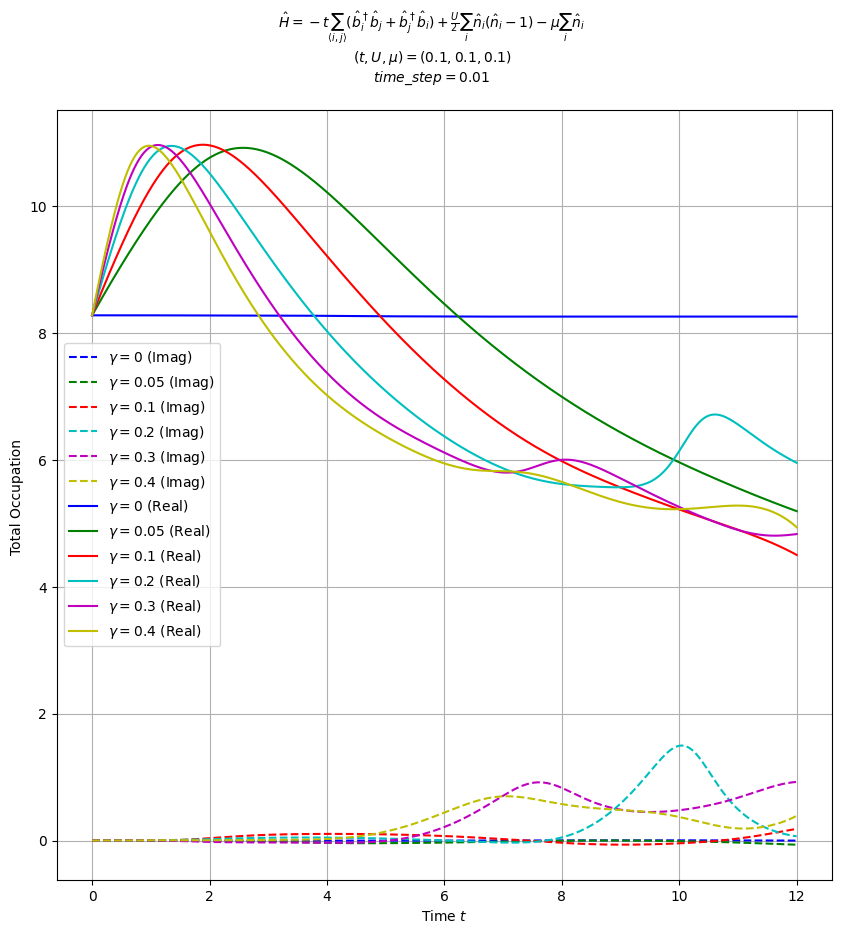

In [60]:
import matplotlib.pyplot as plt

fig1, axs1 = plt.subplots(1, 1, sharex=True, figsize=(10, 10))

colors = ['b', 'g', 'r', 'c', 'm', 'y']

# Plot imaginary parts
axs1.plot(times, np.imag(results_N00), label="$\\gamma = 0$ (Imag)", color=colors[0], linestyle='--')
axs1.plot(times, np.imag(results_N05), label=r"$\gamma = 0.05$ (Imag)", color=colors[1], linestyle='--')
axs1.plot(times, np.imag(results_N10), label=r"$\gamma = 0.1$ (Imag)", color=colors[2], linestyle='--')
axs1.plot(times, np.imag(results_N20), label=r"$\gamma = 0.2$ (Imag)", color=colors[3], linestyle='--')
axs1.plot(times, np.imag(results_N30), label=r"$\gamma = 0.3$ (Imag)", color=colors[4], linestyle='--')
axs1.plot(times, np.imag(results_N), label=r"$\gamma = 0.4$ (Imag)", color=colors[5], linestyle='--')

# Plot real parts
axs1.plot(times, np.real(results_N00), label="$\\gamma = 0$ (Real)", color=colors[0])
axs1.plot(times, np.real(results_N05), label=r"$\gamma = 0.05$ (Real)", color=colors[1])
axs1.plot(times, np.real(results_N10), label=r"$\gamma = 0.1$ (Real)", color=colors[2])
axs1.plot(times, np.real(results_N20), label=r"$\gamma = 0.2$ (Real)", color=colors[3])
axs1.plot(times, np.real(results_N30), label=r"$\gamma = 0.3$ (Real)", color=colors[4])
axs1.plot(times, np.real(results_N), label=r"$\gamma = 0.4$ (Real)", color=colors[5])

plt.suptitle(
    r'$\hat{H} = -t \sum_{\langle i,j \rangle} (\hat{b}_i^\dagger \hat{b}_j + \hat{b}_j^\dagger \hat{b}_i) + \frac{U}{2} \sum_i \hat{n}_i (\hat{n}_i - 1) - \mu \sum_i \hat{n}_i$' + '\n' + 
    r'$(t,U,\mu) = (0.1, 0.1, 0.1) $' + '\n' +
    r'$time\_step = 0.01$' + '\n',
    fontsize=10, y=0.98
)

# axs1.plot(results_N_ttn, label="N_ttn")
# axs1.plot(results_N_t3n, label="N_t3n")

axs1.set_xlabel("Time $t$")
axs1.set_ylabel("Total Occupation ")
axs1.grid(True)
axs1.legend()

In [ ]:
# 3 >> 4 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Define the binary tree structure and data
data = {
  (1, 2): [1, 2, 3, 4],
  (1, 3): [1, 3, 5, 7],
  (2, 4): [1, 1, 2, 2],
  (2, 5): [1, 2, 2, 3],
  (3, 6): [1, 2, 3, 3],
  (3, 7): [1, 1, 2, 4]
}

# Set up the visualization
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Define node positions
positions = {
  1: (0, 0, 0),
  2: (-1, -1, 0),
  3: (1, -1, 0),
  4: (-1.5, -2, 0),
  5: (-0.5, -2, 0),
  6: (0.5, -2, 0),
  7: (1.5, -2, 0)
}

# Draw edges and nodes
for edge in data:
  x = [positions[edge[0]][0], positions[edge[1]][0]]
  y = [positions[edge[0]][1], positions[edge[1]][1]]
  z = [positions[edge[0]][2], positions[edge[1]][2]]
  ax.plot(x, y, z, c='gray', linewidth=1)

for node, pos in positions.items():
  ax.scatter(*pos, c='r', s=100)
  ax.text(*pos, f'Node {node}', fontsize=10, ha='center', va='bottom')

# Define colors for the bars
colors = ['#FFB74D', '#FFEB3B', '#4CAF50', '#80DEEA', '#EF5350']

# Scale factor to adjust the height of the charts
scale_factor = 0.3

# Add 3D bar charts along the edges
for edge, strengths in data.items():
  start_pos = np.array(positions[edge[0]])
  end_pos = np.array(positions[edge[1]])
  n = len(strengths)

  # Generate positions along the edge
  x_positions = np.linspace(start_pos[0], end_pos[0], n)
  y_positions = np.linspace(start_pos[1], end_pos[1], n)

  for i, strength in enumerate(strengths):
      x = x_positions[i]
      y = y_positions[i]
      z = 0  # Start from the base
      dx = dy = 0.1  # Width of the bar
      dz = strength * scale_factor  # Height of the bar
      ax.bar3d(x, y, z, dx, dy, dz, color=colors[i], alpha=0.8)

# Set labels and title
ax.set_xlabel('X', labelpad=10)
ax.set_ylabel('Y', labelpad=10)
ax.set_zlabel('Bond Strength', labelpad=10)
ax.set_title('Binary Tree with Rectangular Area Charts', pad=20)

# Adjust the view
ax.view_init(elev=20, azim=45)

# Set axis limits to ensure all data is visible
ax.set_xlim(-2, 2)
ax.set_ylim(-3, 1)
ax.set_zlim(0, max(max(strengths) for strengths in data.values()) * scale_factor)

# Add a color bar
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap, BoundaryNorm

cmap = ListedColormap(colors)
bounds = [1, 2, 3, 4, 5]
norm = BoundaryNorm(bounds, cmap.N)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.1)
cbar.set_ticks([1.5, 2.5, 3.5, 4.5])
cbar.set_ticklabels(['1', '2', '3', '4'])
cbar.set_label('Bond Strength (Scaled)', fontsize=12)

plt.tight_layout()
plt.show()

In [58]:
print( ttn.total_bond_dim())
print( ttn_ex.total_bond_dim())


30
170
